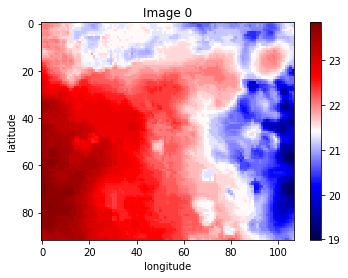

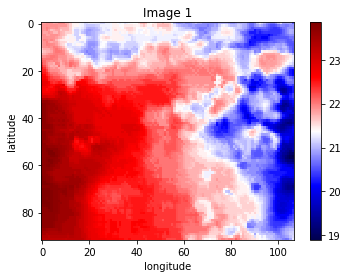

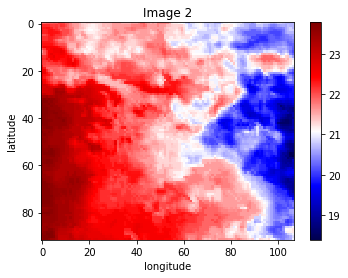

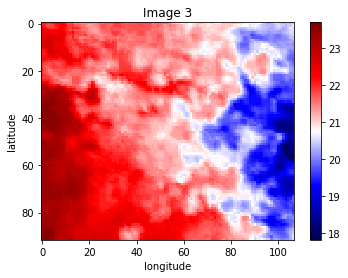

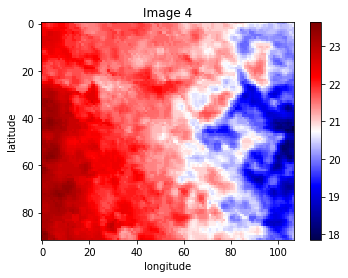

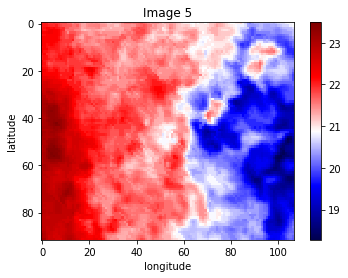

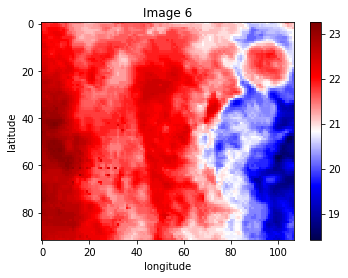

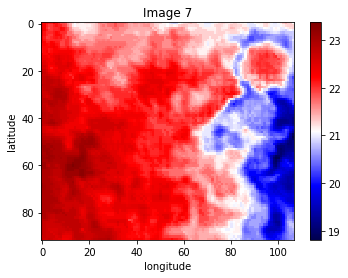

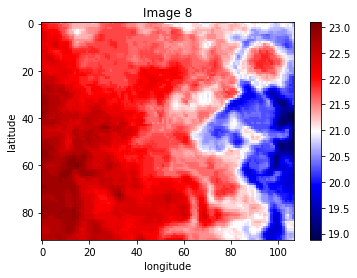

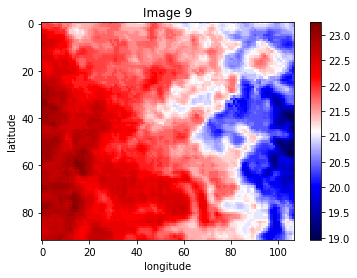

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# initial code given

"""
BEGINNING
Created on Thu Mar  1 13:55:00 2018
load base_hiver
@author: jbrlod
"""
import gzip
import pickle
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
%matplotlib inline
#Name of the base to load
fname = "base_hiver_2008.pklgz"

#image to plot
imind = 2

with gzip.open(fname,"rb") as fp:
    dictio = pickle.load(fp,encoding='latin1')



#SSTMW_in = dictio['CHLA']
SSTMW = dictio['SSTMW']
for imind in range(0,10): # plot all the images
    plt.figure()
    plt.imshow(SSTMW[imind],cmap='seismic')
    plt.colorbar()
    plt.title('Image ' + str(imind))
    plt.xlabel('longitude')
    plt.ylabel('latitude')

"""
@author: jbrlod
END
"""

In [567]:
dictio

{'CHLA': array([[[0.11702691, 0.11638636, 0.11453165, ..., 0.        ,
          0.        , 0.        ],
         [0.11454699, 0.11117801, 0.11117801, ..., 0.        ,
          0.        , 0.        ],
         [0.1058479 , 0.10773491, 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          1.1202

In [942]:
(26.124569-26.041236)*111.12,(26.124569-26.041236)

(9.259962959999962, 0.08333299999999966)

In [2]:
# all libraries used

from keras.layers import Input, Dense, Flatten, \
                            Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Reshape, merge
from keras.models import Model, Sequential
from keras import backend as K
from keras import losses
from keras.optimizers import Adam, RMSprop
from keras.models import Model
from keras.layers.convolutional import Conv2DTranspose,Conv2D
from keras.layers.core import Activation
from keras.layers import MaxPooling2D, concatenate, Input, LeakyReLU
from modelutil import masked_mse
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.callbacks import  EarlyStopping, Callback
from sklearn.model_selection import StratifiedKFold

from keras_adversarial.image_grid_callback import ImageGridCallback
from keras_adversarial import AdversarialModel, simple_gan, gan_targets
from keras_adversarial import normal_latent_sampling, AdversarialOptimizerSimultaneous
from keras_adversarial.legacy import l1l2, Dense, fit
from keras_adversarial import AdversarialModel, fix_names, n_choice
from keras_adversarial import AdversarialOptimizerSimultaneous, normal_latent_sampling

# copy-paste of imports from example_aae.py
from keras.layers import Dense, Reshape, Flatten, Input, merge
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras_adversarial.legacy import l1l2
import keras.backend as K
import pandas as pd
import numpy as np
from keras_adversarial.image_grid_callback import ImageGridCallback
from keras.callbacks import TensorBoard
from keras.callbacks import History 
from keras_adversarial import AdversarialModel, fix_names, n_choice
from keras_adversarial import AdversarialOptimizerSimultaneous, normal_latent_sampling
#from mnist_utils import mnist_data
from keras.layers import LeakyReLU, Activation
import os
import random
import pandas
import pylab

/home/simon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def imreshape(image): # extract 4 new images (64x64) for each image
    
    aux = image
    aux1 = aux[0:64,0:64]
    aux2 = aux[aux.shape[0]-65:aux.shape[0]-1,0:64]
    aux3 = aux[0:64,aux.shape[1]-65:aux.shape[1]-1]
    aux4 = aux[aux.shape[0]-65:aux.shape[0]-1,aux.shape[1]-65:aux.shape[1]-1]
    auxs = [aux1,aux2,aux3,aux4]
    return auxs

#plt.imshow(aux)
#plt.colorbar()
#for i in range(0,4):
#    plt.figure()
#    plt.imshow(auxs[i])
#    plt.colorbar()

In [4]:
# reshape the new64x64 images
sub_images = []
im_reshape = []
sub_images = [ imreshape(SSTMW[i]) for i in range(0,SSTMW.shape[0]) ] # implementation of the imreshape function
sub_images = np.asarray(sub_images)
sub_images = sub_images.reshape(86*4,64,64)
sub_images = np.concatenate((sub_images,sub_images,sub_images),axis=0)


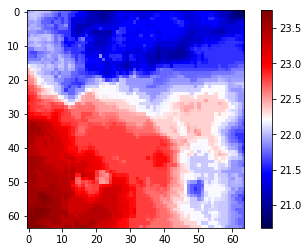

In [584]:
plt.imshow(sub_images[0],cmap='seismic')
plt.colorbar()

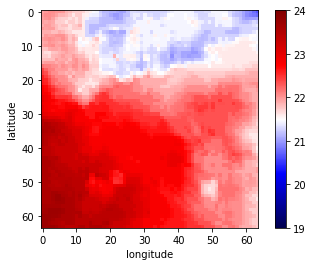

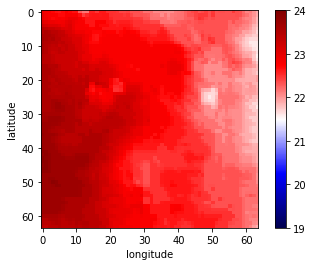

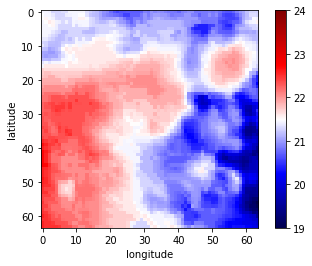

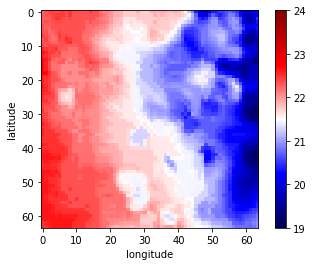

In [938]:
plt.figure()
plt.imshow(sub_images[0],vmin=19,vmax=24,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure()
plt.imshow(sub_images[1],vmin=19,vmax=24,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure()
plt.imshow(sub_images[2],vmin=19,vmax=24,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure()
plt.imshow(sub_images[3],vmin=19,vmax=24,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

In [5]:
# mask with numpy.ma function
import numpy.ma as ma
import random
def hole(image,size):
    aux = image.copy()
    #mask = np.ones(64*64, dtype=int)
    #mask = mask.reshape(64,64)
    #mask[coord[0]:coord[0]+size[0],coord[1]:coord[1]+size[1]] = 0#np.nan
    #mask = mask.reshape(-1,1)
    #image = image.reshape(-1,1)
    #mx = image*mask
    a = random.randint(0,63)
    b = random.randint(0,63)
    aux[a:a+size[0],b:b+size[1]] = 0
    #aux = aux.reshape(64,64)
    return aux

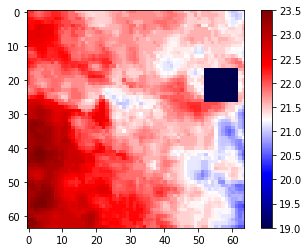

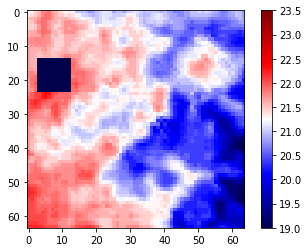

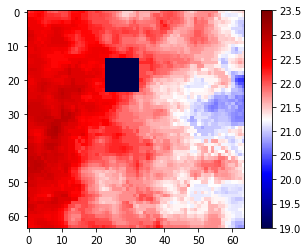

In [600]:
# implementation of the function hole
holed_img1 = hole(sub_images[16],(10,10)) # implementation of the function hole

holed_img2 = hole(sub_images[38],(10,10))

holed_img3 = hole(sub_images[61],(10,10))

plt.figure()
plt.imshow(holed_img1,vmin=19,vmax=23.5,cmap='seismic')
plt.colorbar()

plt.figure()
plt.imshow(holed_img2,vmin=19,vmax=23.5,cmap='seismic')
plt.colorbar()

plt.figure()
plt.imshow(holed_img3,vmin=19,vmax=23.5,cmap='seismic')
plt.colorbar()

In [6]:
# Function to create boundary mask
def nearby_hole(entree,distance):
    mask=np.zeros((64,64))
    for i in range(64):
        for j in range(64):
            if (entree[i,j]==0):
                for i2 in range(i-distance,i+distance+1):
                    for j2 in range(j-distance,j+distance+1):
                        if (i2>=0 and i2<entree.shape[0] and j2>=0 and j2<entree.shape[1]):
                            if(entree[i2,j2]!=0):
                                mask[i2,j2]=1
                            #else:
                             #   mask[i2,j2]=0
    return (mask)

# loss function
def penalized_loss(x,weight_hole=2,weight_ol=16):
    def loss(y_true, y_pred):
        zeronan = 0
        isMask_ol = nearby_hole(x,6)
        isMask_ol = K.cast(isMask_ol,dtype=K.floatx())
        isMask = K.equal(x,zeronan) # mask in the region with hole (integer)
        isMask_square = K.cast(isMask,dtype=K.floatx()) # mask for the pixel where the hole is
        isMask_out = 1 - isMask_square # mask  for the pixels not considering the hole
        #loss_square = K.mean(K.square(y_true*isMask_square-y_pred*isMask_square)) # inside the hole
        #loss_out = K.mean(K.square(y_true*isMask_out-y_pred*isMask_out)) # outside without hole
        #loss_ol = K.mean(K.square(y_true*isMask_ol-y_pred*isMask_ol)) # around the square
        loss_square = losses.mean_squared_error(y_true*isMask_square,y_pred*isMask_square)
        loss_out = losses.mean_squared_error(y_true*isMask_out,y_pred*isMask_out)
        loss_ol = losses.mean_squared_error(y_true*isMask_ol,y_pred*isMask_ol)
        return loss_square*weight_hole + loss_out + loss_ol*weight_ol #  loss outputs sum
    return loss

In [51]:
# autoencoder model
def get_model():
    #mettre les inputs
    inputs = Input(shape=(64, 64, 1))
    #convolution classique
    conv_1 = Conv2D(20, (3, 3), strides=(1, 1), padding='same')(inputs)
    act_1 = Activation('relu')(conv_1)
    #pooling 64->32
    pl_1=MaxPooling2D((2, 2), strides=(2, 2))(act_1)
    #convolution classique2
    conv_2 = Conv2D(15, (3, 3), strides=(1, 1), padding='same')(pl_1)
    act_2 = Activation('relu')(conv_2)
    #pooling 32->16
    pl_2=MaxPooling2D((2, 2), strides=(2, 2))(act_2)
    #convolution classique3
    conv_3 = Conv2D(10, (3, 3), strides=(1, 1), padding='same')(pl_2)
    act_3 = Activation('relu')(conv_3)
    #pooling 16->8
    pl_3=MaxPooling2D((2, 2), strides=(2, 2))(act_3)
    #deconvolution classique
    deconv_1 = Conv2DTranspose(10, (3, 3), strides=(2, 2), padding='same')(pl_3)
    dact_1 = Activation('relu')(deconv_1)
    #ajouter en input de la couche d'entée
    merge_1 = concatenate([dact_1, act_3], axis=3)   
    #refaire une convolution avec les deux informations  
    deconv_2 = Conv2DTranspose(15, (3, 3), strides=(2, 2), padding='same')(merge_1)
    dact_2 = Activation('relu')(deconv_2)
    #ajouter en input de la couche d'entée
    merge_2 = concatenate([dact_2, act_2], axis=3)   
    #refaire une convolution avec les deux informations  
    deconv_3 = Conv2DTranspose(25, (3, 3), strides=(2, 2), padding='same')(merge_2)
    dact_3 = Activation('relu')(deconv_3)
    #ajouter en input de la couche d'entée
    merge_3 = concatenate([dact_3, inputs], axis=3)   
    #refaire une convolution avec les deux informations    
    final = Conv2D(1, (3, 3), strides=(1, 1), padding='same')(merge_3)
    dact_4 = Activation('relu')(final)

    model = Model(inputs=[inputs], outputs=[dact_4])
    model.compile(optimizer='adam', loss=masked_loss)#penalized_loss(inputs))

    return model

In [8]:
# image normalization function
def image_norm(images):
    for a in range(0,images.shape[0]):
        images[a] = ( images[a]- images[a].mean() ) / images[a].std() + 3

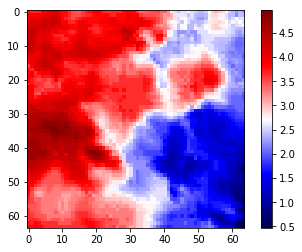

In [20]:
# split dataset into training and test sets
#xtrain, xtest, ytrain, ytest = train_test_split(sub_images, sub_images, test_size=0.2)
xtrain_o, xtest_o, ytrain_o, ytest_o = train_test_split(sub_images, sub_images, test_size=0.2)
xtrain_o, xval_o, ytrain_o, yval_o = train_test_split(xtrain_o, ytrain_o, test_size=0.2)

# normalization per image
xtrain = xtrain_o.copy()
xval = xval_o.copy()
xtest = xtest_o.copy()
ytrain = ytrain_o.copy()
yval = yval_o.copy()
ytest = ytest_o.copy()

image_norm(xtrain)
image_norm(xval)
image_norm(xtest)
image_norm(ytrain)
image_norm(yval)
image_norm(ytest)
    
# reshape to be able to introduce it in the network
xtrain = np.reshape(xtrain, (xtrain.shape[0], 64, 64, 1))
ytrain = np.reshape(ytrain, (ytrain.shape[0], 64, 64, 1))
xval = np.reshape(xval, (xval.shape[0], 64, 64, 1))
yval = np.reshape(yval, (yval.shape[0], 64, 64, 1))
xtest = np.reshape(xtest, (xtest.shape[0], 64, 64, 1))
ytest = np.reshape(ytest, (ytest.shape[0], 64, 64, 1))

ytrain_o.max(),ytrain.max(),xtrain.shape
plt.imshow(ytrain[0,:,:,0],cmap='seismic')
plt.colorbar()

In [ ]:
xtrain_oaux = hole(xtrain_o[])

In [11]:
from keras.callbacks import TensorBoard
b_size = 5
# model training
model = get_model()
model.summary()
ind = 1
alpha = K.variable(value=xtrain)
#aux = K.variable(value=alpha[0:b_size])
aux = K.variable(value=xtrain[0:5])#alpha[0:5]
alpha_aux = K.variable(value=xtrain)
class NewCallback(Callback):
    global alpha
    def __init__(self, aux):
        #self.alpha = alpha
        self.aux = aux
    #def on_batch_begin(self, batch, logs={}):
    #    K.set_value(self.aux, K.get_value(self.aux[0:5]))
    def on_batch_end(self, batch, logs={}):
        global alpha
        global ind
        global alpha_aux
        #if ind == 1:
        alpha_aux = np.roll(K.get_value(alpha_aux),-5,axis=0)
        #else: alpha_aux = np.roll(alpha_aux,-5,axis=0)
        ind = 2
        K.set_value(self.aux, alpha_aux[0:5])
        alpha_aux = K.variable(alpha_aux)


#model.fit(...,callbacks=[NewCallback(alpha), ],...)
#for ep in range(0,70):
#    for bs in range(0,int(xtrain.shape[0]/5)-5):
#        xtrain_aux = xtrain[bs*5:bs*5+4]
#        ytrain_aux = ytrain[bs*5:bs*5+4]
#model.compile(optimizer='adam', loss=penalized_loss(x=aux))
model.fit(xtrain,ytrain,epochs=70,batch_size=b_size)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 20)   200         input_2[0][0]                    
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 64, 64, 20)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 32, 32, 20)   0           activation_8[0][0]               
__________________________________________________________________________________________________
conv2d_6 (

KeyboardInterrupt: 

In [11]:
# saving the model for complete images
#model.save('autoencoder_4_layers')
model = load_model('autoencoder_4_layers',custom_objects={'penalized_loss':penalized_loss})

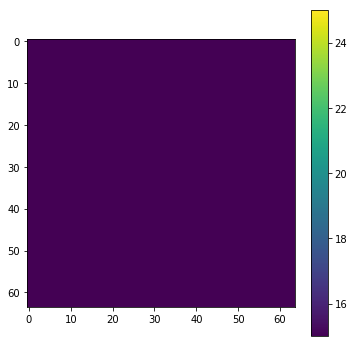

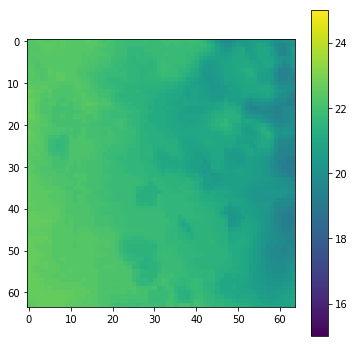

In [13]:
# prediction over the test set

decoded_imgs = model.predict(xtest)

decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0],64,64)
yreal = np.reshape(ytest, (ytest.shape[0], 64, 64))
index = 10
decoded_imgs[50].min()

#plt.subplots(nrows=2,ncols=2)
plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs[0],vmin=15,vmax=25)
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(yreal[5],vmin=15,vmax=25)
plt.colorbar()

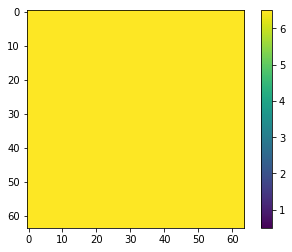

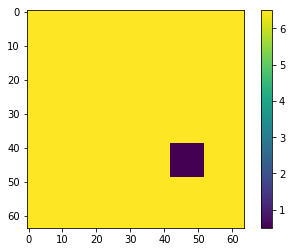

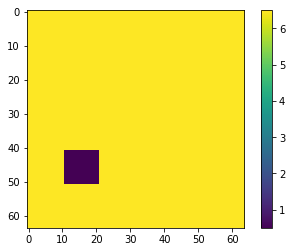

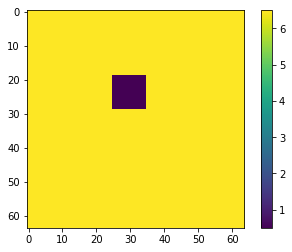

In [193]:
# generate images holes
import random

result = [ hole(sub_images[i],(10,10)) for i in range(0,sub_images.shape[0]) ]# implementation of the function hole
result2 = [ hole(sub_images[i],(10,10)) for i in range(0,sub_images.shape[0]) ]
result3 = [ hole(sub_images[i],(10,10)) for i in range(0,sub_images.shape[0]) ]
result = np.asarray(result)
result2 = np.asarray(result2)
result3 = np.asarray(result3)

plt.imshow(sub_images[7],vmin=-2.5+3,vmax=3.5+3,cmap='jet')
plt.colorbar()
plt.figure()
plt.imshow(result[7],vmin=-2.5+3,vmax=3.5+3,cmap='jet')
plt.colorbar()
plt.figure()
plt.imshow(result2[7],vmin=-2.5+3,vmax=3.5+3,cmap='jet')
plt.colorbar()
plt.figure()
plt.imshow(result3[7],vmin=-2.5+3,vmax=3.5+3,cmap='jet')
plt.colorbar()


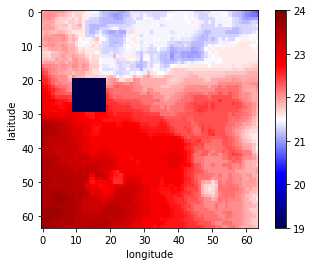

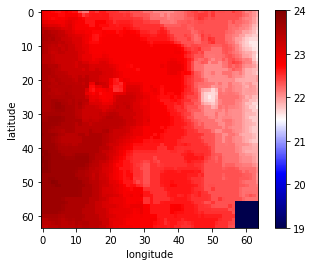

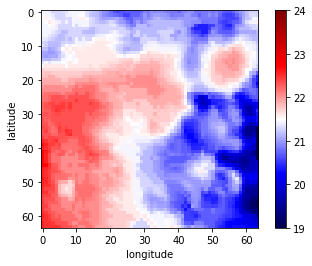

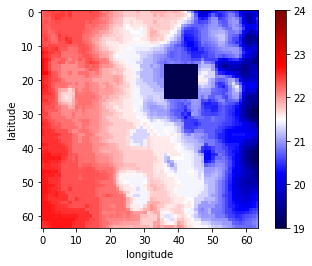

In [970]:
plt.figure()
plt.imshow(result[0],vmin=19,vmax=24,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure()
plt.imshow(result[1],vmin=19,vmax=24,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure()
plt.imshow(result[2],vmin=19,vmax=24,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure()
plt.imshow(result[3],vmin=19,vmax=24,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

In [34]:
xtrain2 = [ hole(xtrain[i],(10,10)) for i in range(0,xtrain.shape[0]) ]
xtrain2 = np.asarray(xtrain2)

xval2 = [ hole(xval[i],(10,10)) for i in range(0,xval.shape[0]) ]
xval2 = np.asarray(xval2)

xtest2 = [ hole(xtest[i],(10,10)) for i in range(0,xtest.shape[0]) ]
xtest2 = np.asarray(xtest2)

(7.388089996132027, 7.388089996132027)

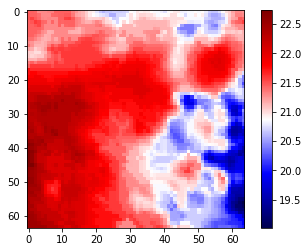

In [49]:
# resize the train and test inputs

#xtrain2_o, xtest2_o, ytrain2_o, ytest2_o = train_test_split(result, sub_images, test_size=0.2)
#xtrain2_o, xval2_o, ytrain2_o, yval2_o = train_test_split(xtrain2_o,ytrain2_o,test_size=0.3)


xtrain2 = np.reshape(xtrain2, (xtrain2.shape[0], 64, 64, 1))
#ytrain2 = np.reshape(ytrain2, (ytrain2.shape[0], 64, 64, 1))
xval2 = np.reshape(xval2, (xval2.shape[0], 64, 64, 1))
#yval2 = np.reshape(yval2, (yval2.shape[0], 64, 64, 1))
xtest2 = np.reshape(xtest2, (xtest2.shape[0], 64, 64, 1))
#ytest2 = np.reshape(ytest2, (ytest2.shape[0], 64, 64, 1))

plt.imshow(sub_images[2],cmap='seismic')
plt.colorbar()

xtrain2.max(),ytrain.max()

In [42]:
# train the model for holed images
#model2 = get_model()

#model2.summary()
cb = [EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto')]
history2 = model2.fit(xtrain2,ytrain,epochs=100,validation_data=(xval2,yval),batch_size=5,callbacks=cb)


Train on 660 samples, validate on 165 samples
Epoch 1/100
660/660 [==============================] - 8s 12ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 2/100
660/660 [==============================] - 8s 13ms/step - loss: 0.0110 - val_loss: 0.0115
Epoch 3/100
660/660 [==============================] - 9s 14ms/step - loss: 0.0109 - val_loss: 0.0112
Epoch 4/100
660/660 [==============================] - 10s 16ms/step - loss: 0.0108 - val_loss: 0.0111
Epoch 5/100
660/660 [==============================] - 10s 16ms/step - loss: 0.0106 - val_loss: 0.0110
Epoch 6/100
660/660 [==============================] - 10s 16ms/step - loss: 0.0105 - val_loss: 0.0109
Epoch 7/100
660/660 [==============================] - 11s 16ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 8/100
660/660 [==============================] - 11s 16ms/step - loss: 0.0103 - val_loss: 0.0106
Epoch 9/100
 80/660 [==>...........................] - ETA: 8s - loss: 0.0104

KeyboardInterrupt: 

In [33]:
#model2.save('autoencoder_single_hole')
#model2 = load_model('autoencoder_single_hole',custom_objects={'penalized_loss':penalized_loss})
model2 = load_model('autoencoder_mult_hole',custom_objects={'penalized_loss':penalized_loss})

OSError: Unable to open file (Unable to open file: name = 'autoencoder_mult_hole', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

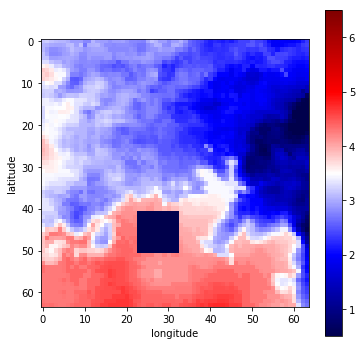

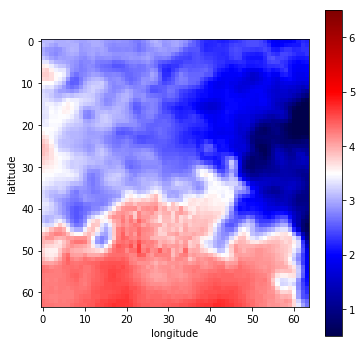

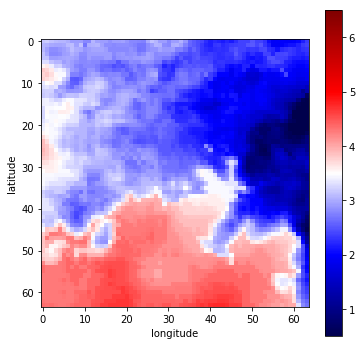

In [43]:
# prediction over the test set

decoded_imgs = model2.predict(xtest2)
decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0],64,64)
yreal = np.reshape(ytest, (ytest.shape[0], 64, 64))
xreal = np.reshape(xtest2, (xtest2.shape[0], 64, 64))
im_ind = 7
decoded_imgs[50].min()
plt.figure(figsize=(6,6))
plt.imshow(xreal[im_ind],vmin=-2.5+3,vmax=3.5+3,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs[im_ind],vmin=-2.5+3,vmax=3.5+3,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(yreal[im_ind],vmin=-2.5+3,vmax=3.5+3,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

#pd.DataFrame(xreal[0])

In [ ]:
decoded_imgs_orig

In [44]:
# create several holes in the image
xtrain3 = []
xval3 = []
xtest3 = []
for k in range(0,xtrain.shape[0]):
    holeim = hole(xtrain[k],(2,2))
    for i in range(0,100):
        holeim = hole(holeim,(6,6))
    xtrain3.append(holeim)
    
for k in range(0,xval.shape[0]):
    holeim = hole(xval[k],(2,2))
    for i in range(0,100):
        holeim = hole(holeim,(6,6))
    xval3.append(holeim)
    
for k in range(0,xtest.shape[0]):
    holeim = hole(xtest[k],(2,2))
    for i in range(0,100):
        holeim = hole(holeim,(6,6))
    xtest3.append(holeim)
    
xtrain3 = np.asarray(xtrain3)
xval3 = np.asarray(xval3)
xtest3 = np.asarray(xtest3)

In [45]:
holeim1 = hole(sub_images[k],(2,2))
for i in range(0,100):
    holeim1 = hole(holeim1,(6,6))
(holeim1)
    
holeim2 = hole(xtrain[k],(2,2))
for i in range(0,100):
    holeim2 = hole(holeim2,(6,6))
xtrain3.append(holeim2)
    
holeim3 = hole(xtrain[k],(2,2))
for i in range(0,100):
    holeim3 = hole(holeim3,(6,6))
xtrain3.append(holeim)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [47]:
#xtrain3, xtest3, ytrain3, ytest3 = train_test_split(ima_holes, sub_images, test_size=0.2)
#xtrain3, xval3, ytrain3, yval3 = train_test_split(xtrain3,ytrain3,test_size=0.3)
# reshape to be able to introduce it in the network
xtrain3 = np.reshape(xtrain3, (xtrain3.shape[0], 64, 64, 1))
#ytrain3 = np.reshape(ytrain3, (ytrain3.shape[0], 64, 64, 1))
xval3 = np.reshape(xval3, (xval3.shape[0], 64, 64, 1))
#yval3 = np.reshape(yval3, (yval3.shape[0], 64, 64, 1))
xtest3 = np.reshape(xtest3, (xtest3.shape[0], 64, 64, 1))
#ytest3 = np.reshape(ytest3, (ytest3.shape[0], 64, 64, 1))

In [58]:
#### training the model for the images with several holes
model3 =  get_model()
cbs = [EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto')]
history3 = model3.fit(xtrain3,ytrain,validation_data=(xval3,yval),epochs=100,batch_size=10,callbacks=cbs)

Train on 577 samples, validate on 248 samples
Epoch 1/100
577/577 [==============================] - 38s 66ms/step - loss: 2.8588 - val_loss: 0.6408
Epoch 2/100
577/577 [==============================] - 32s 55ms/step - loss: 0.4512 - val_loss: 0.3597
Epoch 3/100
577/577 [==============================] - 32s 55ms/step - loss: 0.3280 - val_loss: 0.3069
Epoch 4/100
577/577 [==============================] - 32s 55ms/step - loss: 0.2842 - val_loss: 0.2722
Epoch 5/100
577/577 [==============================] - 32s 55ms/step - loss: 0.2561 - val_loss: 0.2461
Epoch 6/100
577/577 [==============================] - 32s 55ms/step - loss: 0.2364 - val_loss: 0.2276
Epoch 7/100
577/577 [==============================] - 31s 54ms/step - loss: 0.2202 - val_loss: 0.2157
Epoch 8/100
577/577 [==============================] - 32s 55ms/step - loss: 0.2088 - val_loss: 0.2021
Epoch 9/100
577/577 [==============================] - 32s 55ms/step - loss: 0.1981 - val_loss: 0.1942
Epoch 10/100
577/577 [=====

In [63]:
model3.save('autoencoder_mult_holes')
#model3 = load_model('autoencoder_mult_holes',custom_objects={'penalized_loss':penalized_loss})

(207, 64, 64)

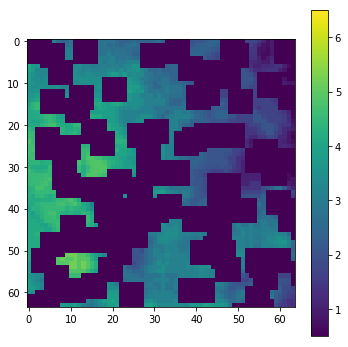

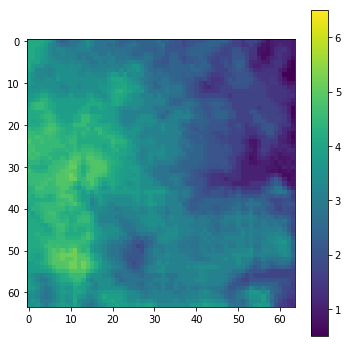

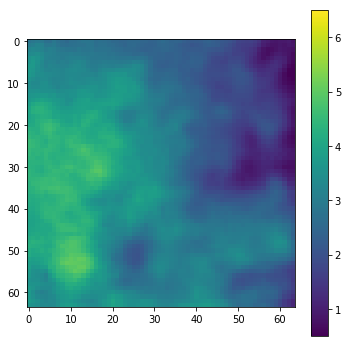

In [225]:
decoded_imgs3 = model3.predict(xtest3)

decoded_imgs3 = decoded_imgs3.reshape(decoded_imgs3.shape[0],64,64)
yreal = np.reshape(ytest, (ytest.shape[0], 64, 64))
xreal = np.reshape(xtest3, (xtest3.shape[0], 64, 64))

im_ind = 7

plt.figure(figsize=(6,6))
plt.imshow(xreal[im_ind],vmin=-2.5+3,vmax=3.5+3,cmap='jet')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(yreal[im_ind],vmin=-2.5+3,vmax=3.5+3,cmap='jet')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs3[im_ind],vmin=-2.5+3,vmax=3.5+3,cmap='jet')
plt.colorbar()
yreal.shape

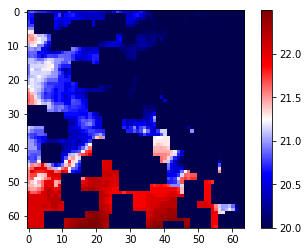

In [50]:
train3 = []
for k in range(0,xtrain_o.shape[0]):
    holeim = hole(xtrain_o[k],(2,2))
    for i in range(0,100):
        holeim = hole(holeim,(6,6))
    train3.append(holeim)
    
val3 = []
for k in range(0,xval_o.shape[0]):
    holeim = hole(xval_o[k],(2,2))
    for i in range(0,100):
        holeim = hole(holeim,(6,6))
    val3.append(holeim)

test3 = []
for k in range(0,xtest_o.shape[0]):
    holeim = hole(xtest_o[k],(2,2))
    for i in range(0,100):
        holeim = hole(holeim,(6,6))
    test3.append(holeim)
    
# training validation and test with real temp values
train3 = np.asarray(train3)
val3 = np.asarray(val3)
test3 = np.asarray(test3)

train3 = np.reshape(train3, (train3.shape[0], 64, 64))
val3 = np.reshape(val3, (val3.shape[0], 64, 64))
test3 = np.reshape(test3, (test3.shape[0], 64, 64))
train3[0][np.nonzero(train3[0])].std()

plt.imshow(test3[im_ind],vmin=20,cmap='seismic')
plt.colorbar()

In [842]:
train3.shape

(660, 64, 64)

(5.564618359245274, -28.272961873877826)

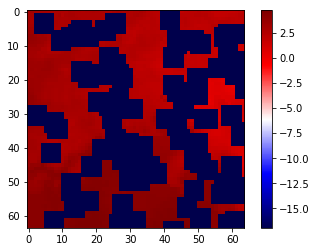

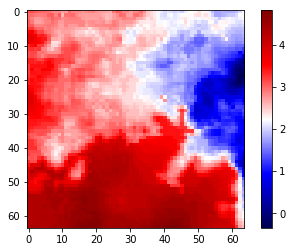

In [51]:
tr3 = np.ones(train3.shape)
vl3 = np.ones(val3.shape)
ts3 = np.ones(test3.shape)
try3 = np.ones(ytrain.shape)
vly3 = np.ones(yval.shape)
tsy3 = np.ones(ytest.shape)

for a in range(0,train3.shape[0]):
    tr3[a] = ( train3[a]- train3[a][np.nonzero(train3[a])].mean() ) \
        / train3[a][np.nonzero(train3[a])].std() + 3
    
for b in range(0,val3.shape[0]):
    vl3[b] = ( val3[b]- val3[b][np.nonzero(val3[b])].mean() ) \
    / val3[b][np.nonzero(val3[b])].std() + 3
    
for c in range(0,test3.shape[0]):
    ts3[c] = ( test3[c]- test3[c][np.nonzero(test3[c])].mean() ) \
    / test3[c][np.nonzero(test3[c])].std() + 3
    
for a in range(0,train3.shape[0]):
    try3[a,:,:,0] = ( ytrain_o[a]- train3[a][np.nonzero(train3[a])].mean() ) \
    / train3[a][np.nonzero(train3[a])].std() + 3
    
for b in range(0,val3.shape[0]):
    vly3[b,:,:,0] = ( yval_o[b]- val3[b][np.nonzero(val3[b])].mean() ) \
    / val3[b][np.nonzero(val3[b])].std() + 3 
    
for c in range(0,test3.shape[0]):
    tsy3[c,:,:,0] = ( ytest_o[c]- test3[c][np.nonzero(test3[c])].mean() ) \
    / test3[c][np.nonzero(test3[c])].std() + 3
    
# training valid and test sets normalized
tr3 = np.asarray(tr3)
vl3 = np.asarray(vl3)
ts3 = np.asarray(ts3)
# outputs normalized considering values of the non-empty zone 
try3 = np.asarray(try3)
vly3 = np.asarray(vly3)
tsy3 = np.asarray(tsy3)

tr3.min()

plt.imshow(ts3[im_ind],cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(tsy3[im_ind,:,:,0],cmap='seismic')
plt.colorbar()
ts3[0].max(),ts3[0].min()

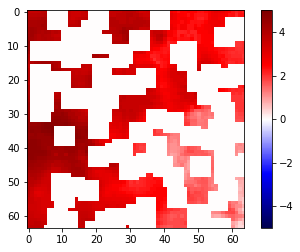

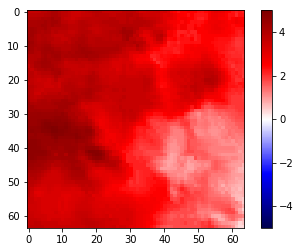

In [52]:
for a in range(0,tr3.shape[0]):
    tr3[a][train3[a] == 0] = 0
for b in range(0,vl3.shape[0]):
    vl3[b][val3[b,:,:] == 0]=0
for c in range(0,ts3.shape[0]):
    ts3[c][test3[c,:,:] == 0]=0

# image with holes in the normalized scale
tr3 = np.reshape(tr3, (tr3.shape[0], 64, 64, 1))
vl3 = np.reshape(vl3, (vl3.shape[0], 64, 64, 1))
ts3 = np.reshape(ts3, (ts3.shape[0], 64, 64, 1))

plt.imshow(tr3[0,:,:,0],vmin=-5,vmax=5,cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(try3[0,:,:,0],vmin=-5,vmax=5,cmap='seismic')
plt.colorbar()

In [868]:
model3aux =  get_model()
cbs = [EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto')]
history3aux = model3aux.fit(tr3,try3,validation_data=(vl3,vly3),epochs=100,batch_size=10,callbacks=cbs)

Train on 660 samples, validate on 165 samples
Epoch 1/100
660/660 [==============================] - 227s 345ms/step - loss: 3.2616 - val_loss: 0.6565
Epoch 2/100
660/660 [==============================] - 37s 57ms/step - loss: 0.4892 - val_loss: 0.3941
Epoch 3/100
660/660 [==============================] - 36s 54ms/step - loss: 0.3465 - val_loss: 0.3138
Epoch 4/100
660/660 [==============================] - 39s 59ms/step - loss: 0.2882 - val_loss: 0.2739
Epoch 5/100
660/660 [==============================] - 30s 45ms/step - loss: 0.2566 - val_loss: 0.2504
Epoch 6/100
660/660 [==============================] - 31s 47ms/step - loss: 0.2379 - val_loss: 0.2345
Epoch 7/100
660/660 [==============================] - 41s 62ms/step - loss: 0.2231 - val_loss: 0.2250
Epoch 8/100
660/660 [==============================] - 35s 52ms/step - loss: 0.2139 - val_loss: 0.2234
Epoch 9/100
660/660 [==============================] - 31s 48ms/step - loss: 0.2047 - val_loss: 0.2115
Epoch 10/100
660/660 [===

(207, 64, 64)

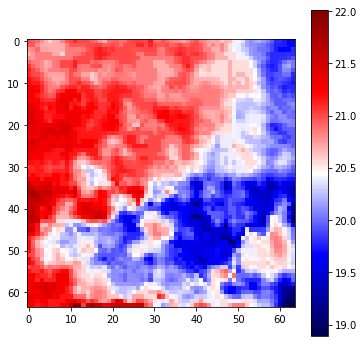

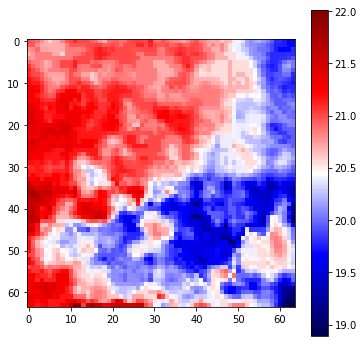

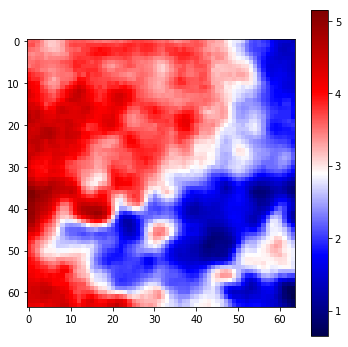

In [890]:
decoded_imgs3aux = model3aux.predict(ts3)

decoded_imgs3aux = decoded_imgs3aux.reshape(decoded_imgs3aux.shape[0],64,64)
yreal = np.reshape(tsy3, (tsy3.shape[0], 64, 64))
xreal = np.reshape(ts3, (ts3.shape[0], 64, 64))

im_ind = 15

plt.figure(figsize=(6,6))
plt.imshow(test3[im_ind],vmin=20,cmap='seismic')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(ytest_o[im_ind],cmap='seismic')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs3aux[im_ind],cmap='seismic')
plt.colorbar()
yreal.shape

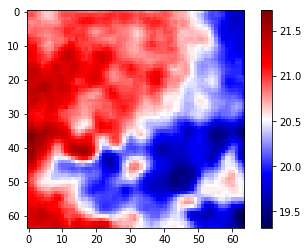

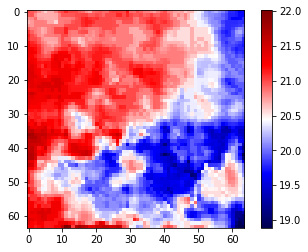

In [871]:
decoded_imgs_orig3aux = np.ones(decoded_imgs3aux.shape)
rmse3aux = []
for index in range(0,decoded_imgs3aux.shape[0]):
    decoded_imgs_orig3aux[index] = (decoded_imgs3aux[index]-3)*test3[index][np.nonzero(test3[index])].std()+ \
                                    test3[index][np.nonzero(test3[index])].mean()
    rmse3aux.append(math.sqrt(np.sum((decoded_imgs_orig3aux[index].reshape(-1,1)- \
                                   ytest_o[index].reshape(-1,1))**2)))

plt.figure()
plt.imshow(decoded_imgs_orig3aux[im_ind], cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(ytest_o[im_ind], cmap='seismic')
plt.colorbar()

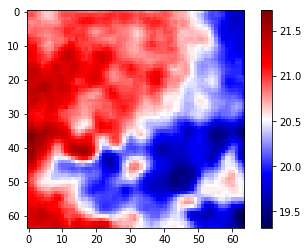

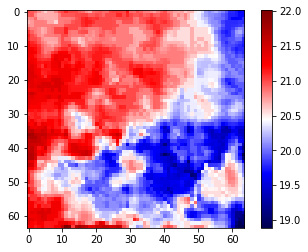

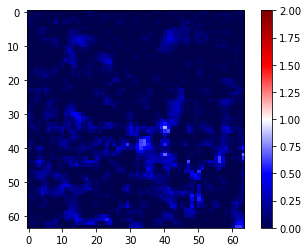

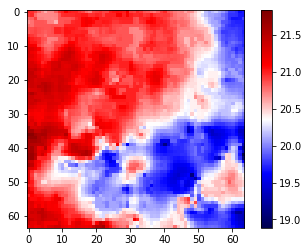

In [872]:
plt.imshow(decoded_imgs_orig3aux[im_ind],cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(xtest_o[im_ind],cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(decoded_imgs_orig3aux[im_ind]-xtest_o[im_ind],vmin=0,vmax=2,cmap='seismic')
plt.colorbar()

aauuxx3aux = ts3.copy()

for n in range(0,decoded_imgs3aux.shape[0]):
    for a in range(0,64):
        for b in range(0,64):
            if aauuxx3aux[n][a,b]==0:
                aauuxx3aux[n][a,b]=decoded_imgs3aux[n][a,b]
                
aauuxx3aux_orig = np.ones(aauuxx3aux.shape)
for index in range(0,aauuxx3aux.shape[0]):
    aauuxx3aux_orig[index] = (aauuxx3aux[index]-3)*test3[index][np.nonzero(test3[index])].std()+ \
                                    test3[index][np.nonzero(test3[index])].mean()
                
plt.figure()
plt.imshow(aauuxx3aux_orig[im_ind,:,:,0],cmap='seismic')
plt.colorbar()

In [369]:
# Adversatial model
outreal = []
for i in range(0,yreal_tot.shape[0]):
    outreal.append(random.randint(0,1))
outreal = np.asarray(outreal)
outpred = 1 - outreal

gan_in = np.ones(yreal_tot.shape[0]*2*64*64)
gan_in = np.reshape(gan_in,(yreal_tot.shape[0],64,64,2))

for k in range(0,yreal_tot.shape[0]):
    gan_in[k,:,:,outreal[k]] = yreal_tot[k]
    gan_in[k,:,:,outpred[k]] = decoded_tot[k]

In [370]:
# discriminator model
def get_discriminator():
    inputs = Input(shape=(64, 64, 2))
    conv_1 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(inputs)
    act_1 = Activation('relu')(conv_1)
    pl_1=MaxPooling2D((2, 2), strides=(2, 2))(act_1)
    conv_2 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(pl_1)
    act_2 = Activation('relu')(conv_2)
    pl_2=MaxPooling2D((2, 2), strides=(2, 2))(act_2)
    conv_3 = Conv2D(8, (3, 3), strides=(1, 1), padding='same')(pl_2)
    act_3 = Activation('relu')(conv_3)
    pl_3=MaxPooling2D((2, 2), strides=(2, 2))(act_3)
    fc=Flatten()(pl_3)
    fc_2=Dense(40)(fc)
    act_4=Activation('relu')(fc_2)
    fc_3=Dense(25)(act_4)
    act_5=Activation('relu')(fc_3)
    fc_4=Dense(10)(act_5)
    act_6=Activation('relu')(fc_4)
    fc_5=Dense(1)(act_6)
    act_7=Activation('sigmoid')(fc_5)
   
    rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    #sgd = optimizers.SGD(lr=0.01, clipvalue=0.5)
    #adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    #adamax = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
   
    model = Model(inputs=[inputs], outputs=[act_7])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [53]:
gan_in.shape

(344, 64, 64, 2)

In [371]:
xtr,xts,ytr,yts = train_test_split(gan_in,outreal,test_size=0.2)
#ytr = np.reshape(ytr,(62,))

In [372]:
model4 = get_discriminator()
model4.summary()
model4.fit(xtr,ytr,epochs=40,batch_size=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        (None, 64, 64, 2)         0         
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 64, 64, 32)        608       
_________________________________________________________________
activation_420 (Activation)  (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_181 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_236 (Conv2D)          (None, 32, 32, 16)        4624      
_________________________________________________________________
activation_421 (Activation)  (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_182 (MaxPoolin (None, 16, 16, 16)        0         
__________

KeyboardInterrupt: 

In [26]:
#model4.save('discriminator_model')
model4 = load_model('discriminator_model')

scores = model4.evaluate(xts,yts)
print("%s: %.2f%%" % (model4.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model4.metrics_names[1], scores[1]*100))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
69/69 [==============================] - 0s 3ms/step
loss: 0.04%
acc: 100.00%


In [53]:
# GAN implementation functions definition

def model_encoder():#latent_dim, input_shape, hidden_dim=512, reg=lambda: l1l2(1e-7, 0)):
    #x = Input(input_shape, name="x")
    #h = Flatten()(x)
    #h = Dense(hidden_dim, name="encoder_h1", W_regularizer=reg())(h)
    #h = LeakyReLU(0.2)(h)
    #h = Dense(hidden_dim, name="encoder_h2", W_regularizer=reg())(h)
    #h = LeakyReLU(0.2)(h)
    #mu = Dense(latent_dim, name="encoder_mu", W_regularizer=reg())(h)
    #log_sigma_sq = Dense(latent_dim, name="encoder_log_sigma_sq", W_regularizer=reg())(h)
    #z = merge([mu, log_sigma_sq], mode=lambda p: p[0] + K.random_normal(K.shape(p[0])) * K.exp(p[1] / 2),
    #          output_shape=lambda p: p[0])
    #return Model(x, z, name="encoder")

    #mettre les inputs
    inputs = Input(shape=(64, 64,1))
    #convolution classique
    conv_1 = Conv2D(20, (3, 3), strides=(1, 1), padding='same')(inputs)
    act_1 = Activation('relu')(conv_1)
    #pooling 64->32
    pl_1=MaxPooling2D((2, 2), strides=(2, 2))(act_1)
    #convolution classique2
    conv_2 = Conv2D(15, (3, 3), strides=(1, 1), padding='same')(pl_1)
    act_2 = Activation('relu')(conv_2)
    #pooling 32->16
    pl_2=MaxPooling2D((2, 2), strides=(2, 2))(act_2)
    #convolution classique3
    conv_3 = Conv2D(10, (3, 3), strides=(1, 1), padding='same')(pl_2)
    act_3 = Activation('relu')(conv_3)
    #pooling 16->8
    pl_3=MaxPooling2D((2, 2), strides=(2, 2))(act_3)
    return Model(inputs, pl_3, name="encoder")

def model_generator():#latent_dim, input_shape, hidden_dim=512, reg=lambda: l1l2(1e-7, 0)):
    #return Sequential([
    #    Dense(hidden_dim, name="generator_h1", input_dim=latent_dim, W_regularizer=reg()),
    #    LeakyReLU(0.2),
    #    Dense(hidden_dim, name="generator_h2", W_regularizer=reg()),
    #    LeakyReLU(0.2),
    #    Dense(np.prod(input_shape), name="generator_x_flat", W_regularizer=reg()),
    #    Activation('sigmoid'),
    #    Reshape(input_shape, name="generator_x")],
    #    name="generator")

    #pl_3=MaxPooling2D((2, 2), strides=(2, 2))(act_3)
    inputs = Input(shape=(8,8,10))
    #deconvolution classique
    deconv_1 = Conv2DTranspose(10, (3, 3), strides=(2, 2), padding='same')(inputs)
    dact_1 = Activation('relu')(deconv_1)
    #ajouter en input de la couche d'entée
    merge_1 = dact_1#concatenate([dact_1, act_3], axis=3)   
    #refaire une convolution avec les deux informations  
    deconv_2 = Conv2DTranspose(15, (3, 3), strides=(2, 2), padding='same')(merge_1)
    dact_2 = Activation('relu')(deconv_2)
    #ajouter en input de la couche d'entée
    merge_2 = dact_2#concatenate([dact_2, act_2], axis=3)   
    #refaire une convolution avec les deux informations  
    deconv_3 = Conv2DTranspose(25, (3, 3), strides=(2, 2), padding='same')(merge_2)
    dact_3 = Activation('relu')(deconv_3)
    #ajouter en input de la couche d'entée
    merge_3 = dact_3#concatenate([dact_3, inputs], axis=3)   
    #refaire une convolution avec les deux informations    
    final = Conv2D(1, (3, 3), strides=(1, 1), padding='same')(merge_3)
    dact_4 = Activation('relu')(final)
    return Model(inputs,dact_4, name='generator')

def model_discriminator():#latent_dim, output_dim=1, hidden_dim=512,reg=lambda: l1l2(1e-7, 1e-7)):
    
    #input1 = input1.reshape(64,64,1)
    #input2 = input2.reshape(64,64,1)
    #inputs = np.concatenate((input1,input2),axis=2)
    inputs = Input(shape=(64, 64,2))
    conv_1 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(inputs)
    act_1 = Activation('relu')(conv_1)
    pl_1=MaxPooling2D((2, 2), strides=(2, 2))(act_1)
    conv_2 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(pl_1)
    act_2 = Activation('relu')(conv_2)
    pl_2=MaxPooling2D((2, 2), strides=(2, 2))(act_2)
    conv_3 = Conv2D(8, (3, 3), strides=(1, 1), padding='same')(pl_2)
    act_3 = Activation('relu')(conv_3)
    pl_3=MaxPooling2D((2, 2), strides=(2, 2))(act_3)
    fc=Flatten()(pl_3)
    fc_2=Dense(40)(fc)
    act_4=Activation('relu')(fc_2)
    fc_3=Dense(25)(act_4)
    act_5=Activation('relu')(fc_3)
    fc_4=Dense(10)(act_5)
    act_6=Activation('relu')(fc_4)
    fc_5=Dense(1)(act_6)
    act_7=Activation('sigmoid')(fc_5)
    return Model(inputs,act_7)

def model_autoencoder():
    #mettre les inputs
    inputs = Input(shape=(64, 64, 1))
    #convolution classique
    conv_1 = Conv2D(20, (3, 3), strides=(1, 1), padding='same')(inputs)
    act_1 = Activation('relu')(conv_1)
    #pooling 64->32
    pl_1=MaxPooling2D((2, 2), strides=(2, 2))(act_1)
    #convolution classique2
    conv_2 = Conv2D(15, (3, 3), strides=(1, 1), padding='same')(pl_1)
    act_2 = Activation('relu')(conv_2)
    #pooling 32->16
    pl_2=MaxPooling2D((2, 2), strides=(2, 2))(act_2)
    #convolution classique3
    conv_3 = Conv2D(10, (3, 3), strides=(1, 1), padding='same')(pl_2)
    act_3 = Activation('relu')(conv_3)
    #pooling 16->8
    pl_3=MaxPooling2D((2, 2), strides=(2, 2))(act_3)
    #deconvolution classique
    deconv_1 = Conv2DTranspose(10, (3, 3), strides=(2, 2), padding='same')(pl_3)
    dact_1 = Activation('relu')(deconv_1)
    #ajouter en input de la couche d'entée
    merge_1 = concatenate([dact_1, act_3], axis=3)   
    #refaire une convolution avec les deux informations  
    deconv_2 = Conv2DTranspose(15, (3, 3), strides=(2, 2), padding='same')(merge_1)
    dact_2 = Activation('relu')(deconv_2)
    #ajouter en input de la couche d'entée
    merge_2 = concatenate([dact_2, act_2], axis=3)   
    #refaire une convolution avec les deux informations  
    deconv_3 = Conv2DTranspose(25, (3, 3), strides=(2, 2), padding='same')(merge_2)
    dact_3 = Activation('relu')(deconv_3)
    #ajouter en input de la couche d'entée
    merge_3 = concatenate([dact_3, inputs], axis=3)   
    #refaire une convolution avec les deux informations    
    final = Conv2D(1, (3, 3), strides=(1, 1), padding='same')(merge_3)
    dact_4 = Activation('relu')(final)
    
    #model = Model(inputs=[inputs], outputs=[concatenate([inputs,dact_4],axis=3)])
    model = Model(inputs=[inputs], outputs=[dact_4])
    return model

In [54]:
#def example_aae(path, adversarial_optimizer):
path = "output/aae"
adversarial_optimizer = AdversarialOptimizerSimultaneous()

# generator (z -> x)
generator = model_generator()#latent_dim, input_shape)
# encoder (x ->z)
encoder = model_encoder()#latent_dim, input_shape)
# autoencoder (x -> x')
autoencoder = model_autoencoder()#Model(encoder.inputs, generator(encoder(encoder.inputs)))
# discriminator (z -> y)
discriminator = model_discriminator()#latent_dim)

# assemple AAE
x = autoencoder.inputs[0]
#z = encoder(x)
xpred = autoencoder(x)
#zreal = x#normal_latent_sampling((latent_dim,))(x)
#yreal = discriminator(concatenate([x,xpred],axis=3))
yreal = discriminator(concatenate([x,xpred],axis=3))
#yfake = discriminator(xpred)
aae = Model(x, fix_names([xpred, yreal], ["xpred", "yreal"]))

# print summary of models
#generator.summary()
autoencoder.summary()
discriminator.summary()
#autoencoder.summary()

aux2 = K.variable(value=xtrain2[0:5])
# build adversarial model
#generative_params = generator.trainable_weights + encoder.trainable_weights
model5 = AdversarialModel(base_model=aae,
                         player_params=[autoencoder.trainable_weights, discriminator.trainable_weights],
                         player_names=["autoencoder", "discriminator"])
model5.adversarial_compile(adversarial_optimizer=adversarial_optimizer,
                          player_optimizers=['adam', Adam(1e-3, decay=1e-3)],
                          loss={"yreal": "binary_crossentropy",
                                "xpred": penalized_loss(x)},
                          player_compile_kwargs=[{"loss_weights": {"yreal": 1e-2, "xpred": 1}}] * 2)


# callback for input mask
alpha2 = K.variable(value=xtrain2)
aux2 = K.variable(value=xtrain2[0:5])#alpha[0:5]
alpha_aux2 = K.variable(value=xtrain2)
ind = 1

# not used
class NewCallback2(Callback):
    def __init__(self, aux2):
        self.aux2 = aux2
    def on_batch_end(self, batch, logs={}):
        global alpha2
        global ind
        global alpha_aux2
        if ind==1: alpha_aux2 = np.roll(K.get_value(alpha_aux2),-5,axis=0)
        else: alpha_aux2 = np.roll(alpha_aux2,-5,axis=0)
        ind = 2
        K.set_value(self.aux2, alpha_aux2[0:5])


# save history
#df = pd.DataFrame(history.history)
#df.to_csv(os.path.join(path, "history.csv"))

# save model
#encoder.save(os.path.join(path, "encoder.h5"))
#generator.save(os.path.join(path, "generator.h5"))
#discriminator.save(os.path.join(path, "discriminator.h5"))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 20)   200         input_3[0][0]                    
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 64, 64, 20)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 32, 32, 20)   0           activation_8[0][0]               
____________________________________

In [408]:
xtrain2.shape, xval2.shape,xtest2.shape,ytrain.shape,yval.shape#,ytest2.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# train model with images having only one hole

n = xtrain2.shape[0] 
y = [ytrain, np.ones((n, 1)), ytrain, np.ones((n, 1))]
#y = [ytrain, np.ones((n, 1)), np.zeros((n, 1)), ytrain, np.zeros((n, 1)), np.ones((n, 1))]
ntest = xtest2.shape[0]
nval = xval2.shape[0]
yvalid = [yval, np.ones((nval, 1)), yval, np.ones((nval, 1))]
yt = [ytest, np.ones((ntest, 1)), ytest, np.ones((ntest, 1))]
#ytest = [ytest, np.ones((ntest, 1)), np.zeros((ntest, 1)), ytest, np.zeros((ntest, 1)), np.ones((ntest, 1))]
es = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')]

history5 = model5.fit(x=(xtrain2), y=y, validation_data=(xval2,yvalid),
                    nb_epoch=100, batch_size=5,callbacks=es)

/home/simon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 660 samples, validate on 165 samples
Epoch 1/100
660/660 [==============================] - 44s 66ms/step - loss: 2.0087 - autoencoder_loss: 1.0044 - autoencoder_xpred_loss: 1.0042 - autoencoder_yreal_loss: 0.0133 - discriminator_loss: 1.0044 - discriminator_xpred_loss: 1.0042 - discriminator_yreal_loss: 0.0133 - val_loss: 0.1304 - val_autoencoder_loss: 0.0652 - val_autoencoder_xpred_loss: 0.0652 - val_autoencoder_yreal_loss: 1.1921e-07 - val_discriminator_loss: 0.0652 - val_discriminator_xpred_loss: 0.0652 - val_discriminator_yreal_loss: 1.1921e-07
Epoch 2/100
660/660 [==============================] - 42s 63ms/step - loss: 0.1019 - autoencoder_loss: 0.0509 - autoencoder_xpred_loss: 0.0509 - autoencoder_yreal_loss: 1.1921e-07 - discriminator_loss: 0.0509 - discriminator_xpred_loss: 0.0509 - discriminator_yreal_loss: 1.1921e-07 - val_loss: 0.0846 - val_autoencoder_loss: 0.0423 - val_autoencoder_xpred_loss: 0.0423 - val_autoencoder_yreal_loss: 1.1921e-07 - val_discriminator_los

660/660 [==============================] - 41s 62ms/step - loss: 0.0234 - autoencoder_loss: 0.0117 - autoencoder_xpred_loss: 0.0117 - autoencoder_yreal_loss: 1.1921e-07 - discriminator_loss: 0.0117 - discriminator_xpred_loss: 0.0117 - discriminator_yreal_loss: 1.1921e-07 - val_loss: 0.0246 - val_autoencoder_loss: 0.0123 - val_autoencoder_xpred_loss: 0.0123 - val_autoencoder_yreal_loss: 1.1921e-07 - val_discriminator_loss: 0.0123 - val_discriminator_xpred_loss: 0.0123 - val_discriminator_yreal_loss: 1.1921e-07
Epoch 17/100
660/660 [==============================] - 42s 64ms/step - loss: 0.0227 - autoencoder_loss: 0.0114 - autoencoder_xpred_loss: 0.0114 - autoencoder_yreal_loss: 1.1921e-07 - discriminator_loss: 0.0114 - discriminator_xpred_loss: 0.0114 - discriminator_yreal_loss: 1.1921e-07 - val_loss: 0.0233 - val_autoencoder_loss: 0.0117 - val_autoencoder_xpred_loss: 0.0117 - val_autoencoder_yreal_loss: 1.1921e-07 - val_discriminator_loss: 0.0117 - val_discriminator_xpred_loss: 0.0117 

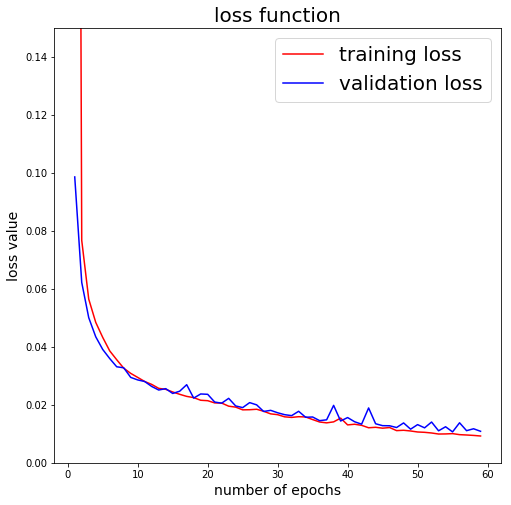

In [442]:
trloss = history5.history['loss']
trloss = np.asarray(trloss)
vloss = history5.history['val_loss']
vloss = np.asarray(vloss)
ep = np.linspace(1,vloss.shape[0],vloss.shape[0])

plt.figure(figsize=(8,8))
plt.plot(ep,trloss,'r',label='training loss')
plt.plot(ep,vloss,'b',label='validation loss')
plt.ylim([0, 0.15])
plt.title('loss function',fontsize=20)
plt.xlabel('number of epochs',fontsize=14)
plt.ylabel('loss value',fontsize=14)
plt.legend(fontsize=20)

In [69]:
autoencoder.save(os.path.join(path,"autoencoder1hole.h5")) #autoencodernholes.h5
generator.save(os.path.join(path, "generator1hole.h5")) #generatornholes.h5

(207, 64, 64)


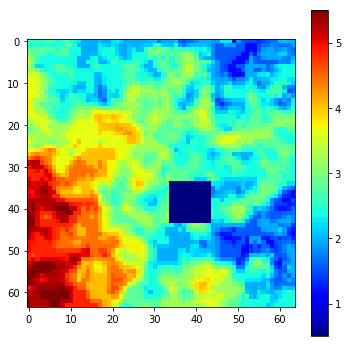

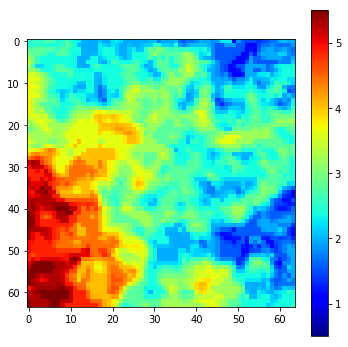

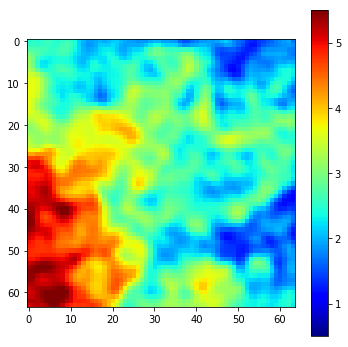

In [578]:
#autoencoder = load_model(os.path.join(path, "autoencoder.h5"))

#decoded_imgs = autoencoder.predict(xtest3)
decoded_imgs5 = model5.predict(xtest2)
decoded_imgs5 = np.asarray(decoded_imgs5[0])
print(decoded_imgs.shape)

decoded_imgs5 = decoded_imgs5.reshape(decoded_imgs5.shape[0],64,64)
ytest = np.asarray(ytest)
yreal2 = np.reshape(ytest, (ytest.shape[0], 64, 64))
xreal2 = np.reshape(xtest2, (xtest2.shape[0], 64, 64))
im_ind = 7

plt.figure(figsize=(6,6))
plt.imshow(xreal2[im_ind],vmin=-2.5+3,vmax=2.5+3,cmap='jet')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(yreal2[im_ind],vmin=-2.5+3,vmax=2.5+3,cmap='jet')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs5[im_ind],vmin=-2.5+3,vmax=2.5+3,cmap='jet')
plt.colorbar()

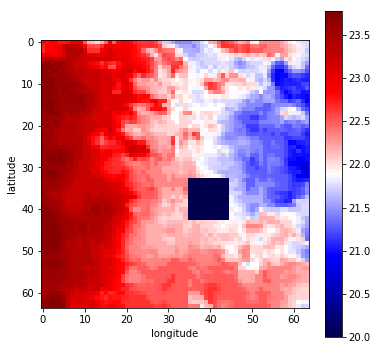

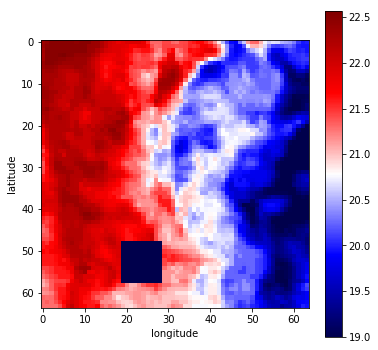

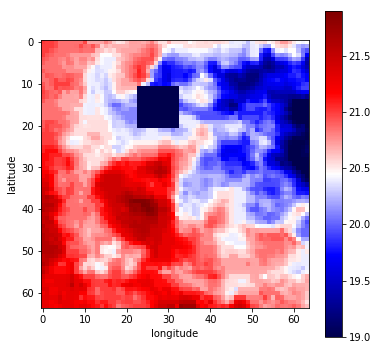

In [937]:
plt.figure(figsize=(6,6))
plt.imshow(result[im_ind+2,:,:],vmin=20,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(result[im_ind+20],vmin=19,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(result[im_ind+120],vmin=19,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

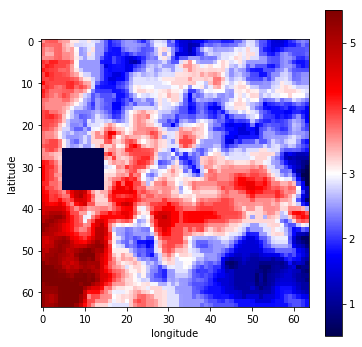

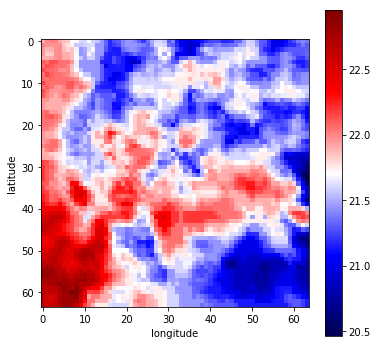

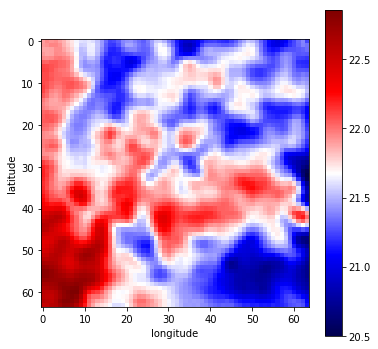

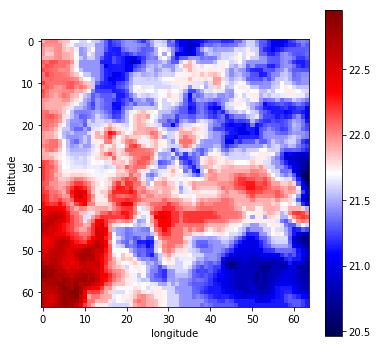

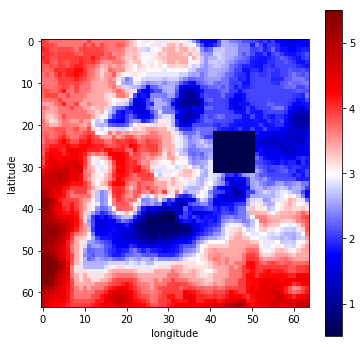

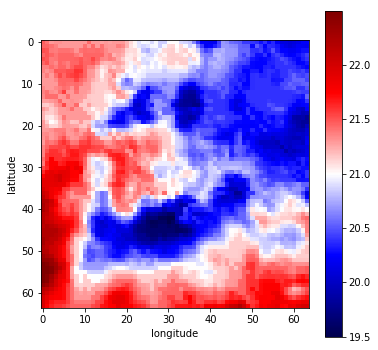

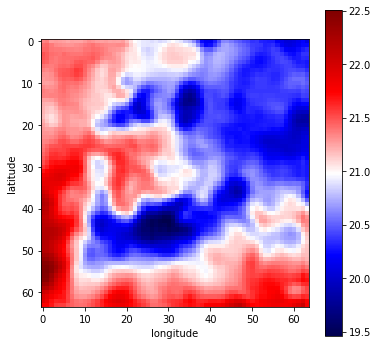

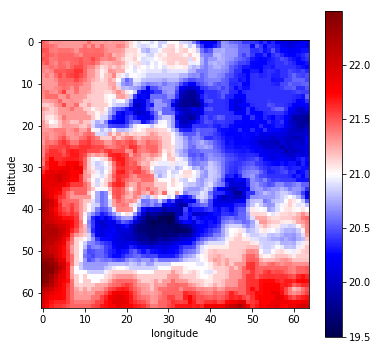

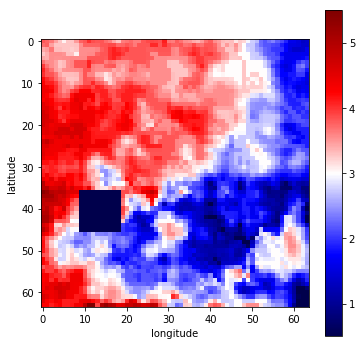

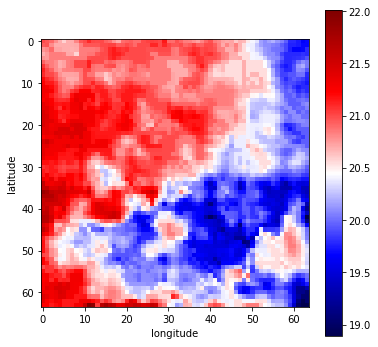

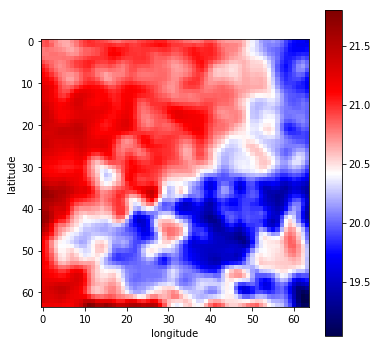

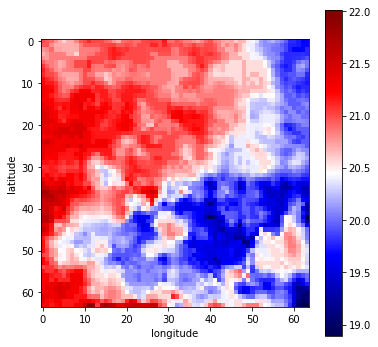

In [908]:
aauuxx2 = xreal2.copy()
for n in range(0,decoded_imgs5.shape[0]):
    for a in range(0,64):
        for b in range(0,64):
            if aauuxx2[n][a,b]==0:
                aauuxx2[n][a,b]=decoded_imgs5[n][a,b]

###############################
plt.figure(figsize=(6,6))
plt.imshow(xreal2[im_ind+2],vmin=-2.5+3,vmax=2.5+3,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(ytest_o[im_ind+2],cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs_orig5[im_ind+2],cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(aauuxx2_orig[im_ind+2],cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
###############################
plt.figure(figsize=(6,6))
plt.imshow(xreal2[im_ind+10],vmin=-2.5+3,vmax=2.5+3,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(ytest_o[im_ind+10],cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs_orig5[im_ind+10],cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(aauuxx2_orig[im_ind+10],cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
###############################
plt.figure(figsize=(6,6))
plt.imshow(xreal2[im_ind+8],vmin=-2.5+3,vmax=2.5+3,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(ytest_o[im_ind+8],cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs_orig5[im_ind+8],cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(aauuxx2_orig[im_ind+8],cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

In [901]:
#generative_params = generator.trainable_weights + encoder.trainable_weights
model6 = AdversarialModel(base_model=aae,
                         player_params=[autoencoder.trainable_weights, discriminator.trainable_weights],
                         player_names=["autoencoder", "discriminator"])
model6.adversarial_compile(adversarial_optimizer=adversarial_optimizer,
                          player_optimizers=['adam', Adam(1e-3, decay=1e-3)],
                          loss={"yreal": "binary_crossentropy",
                                "xpred": penalized_loss(x)},
                          player_compile_kwargs=[{"loss_weights": {"yreal": 1e-2, "xpred": 1}}] * 2)

In [902]:
# train model with images having multiple hole

n = tr3.shape[0] 
y = [try3, np.ones((n, 1)), try3, np.ones((n, 1))]
#y = [ytrain, np.ones((n, 1)), np.zeros((n, 1)), ytrain, np.zeros((n, 1)), np.ones((n, 1))]
ntest = ts3.shape[0]
nval = vl3.shape[0]
yvalid = [vly3, np.ones((nval, 1)), vly3, np.ones((nval, 1))]
yt = [tsy3, np.ones((ntest, 1)), tsy3, np.ones((ntest, 1))]

#ytest = [ytest, np.ones((ntest, 1)), np.zeros((ntest, 1)), ytest, np.zeros((ntest, 1)), np.ones((ntest, 1))]
es = [EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')]

history6 = model6.fit(x=tr3, y=y, validation_data=(vl3,yvalid),
                    nb_epoch=100, batch_size=10,callbacks=es)

/home/simon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 660 samples, validate on 165 samples
Epoch 1/100
660/660 [==============================] - 393s 595ms/step - loss: 0.1840 - autoencoder_loss: 0.0920 - autoencoder_xpred_loss: 0.0920 - autoencoder_yreal_loss: 1.1921e-07 - discriminator_loss: 0.0920 - discriminator_xpred_loss: 0.0920 - discriminator_yreal_loss: 1.1921e-07 - val_loss: 0.1782 - val_autoencoder_loss: 0.0891 - val_autoencoder_xpred_loss: 0.0891 - val_autoencoder_yreal_loss: 1.1921e-07 - val_discriminator_loss: 0.0891 - val_discriminator_xpred_loss: 0.0891 - val_discriminator_yreal_loss: 1.1921e-07
Epoch 2/100
660/660 [==============================] - 46s 70ms/step - loss: 0.1579 - autoencoder_loss: 0.0789 - autoencoder_xpred_loss: 0.0789 - autoencoder_yreal_loss: 1.1921e-07 - discriminator_loss: 0.0789 - discriminator_xpred_loss: 0.0789 - discriminator_yreal_loss: 1.1921e-07 - val_loss: 0.1772 - val_autoencoder_loss: 0.0886 - val_autoencoder_xpred_loss: 0.0886 - val_autoencoder_yreal_loss: 1.1921e-07 - val_discrim

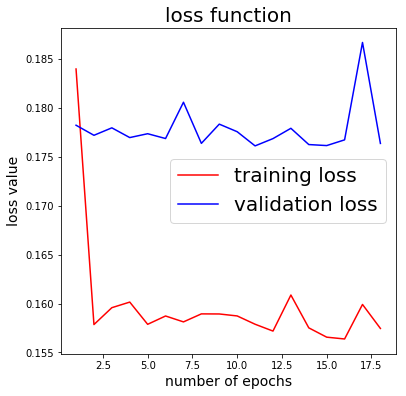

In [903]:
trloss2 = history6.history['loss']
trloss2 = np.asarray(trloss2)
vloss2 = history6.history['val_loss']
vloss2 = np.asarray(vloss2)
ep2 = np.linspace(1,vloss2.shape[0],vloss2.shape[0])

plt.figure(figsize=(6,6))
plt.plot(ep2,trloss2,'r',label='training loss')
plt.plot(ep2,vloss2,'b',label='validation loss')
plt.title('loss function',fontsize=20)
plt.xlabel('number of epochs',fontsize=14)
plt.ylabel('loss value',fontsize=14)
plt.legend(fontsize=20)


In [78]:
autoencoder.save(os.path.join(path,"autoencodernholes.h5")) 
generator.save(os.path.join(path, "generatornholes.h5")) 

(207, 64, 64, 1)


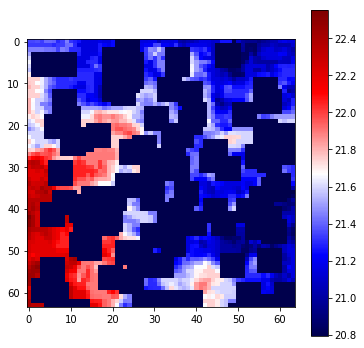

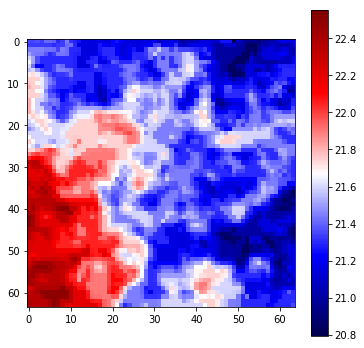

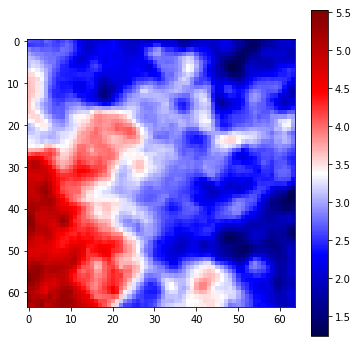

In [904]:
#autoencoder = load_model(os.path.join(path, "autoencoder.h5"))

#decoded_imgs = autoencoder.predict(xtest3)
decoded_imgs6 = model6.predict(ts3)
decoded_imgs6 = np.asarray(decoded_imgs6[0])
print(decoded_imgs6.shape)

decoded_imgs6 = decoded_imgs6.reshape(decoded_imgs6.shape[0],64,64)
yreal3 = np.reshape(ytest, (ytest.shape[0], 64, 64))
xreal3 = np.reshape(test3, (test3.shape[0], 64, 64))
im_ind = 7

plt.figure(figsize=(6,6))
plt.imshow(test3[im_ind],vmin=ytest_o[im_ind].min(),cmap='seismic')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(ytest_o[im_ind],cmap='seismic')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs6[im_ind],cmap='seismic')
plt.colorbar()

In [353]:
# rmse of zones with and without holes



AttributeError: 'History' object has no attribute 'eval'

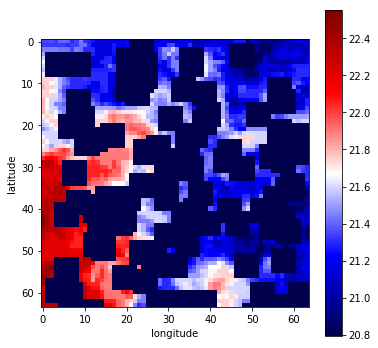

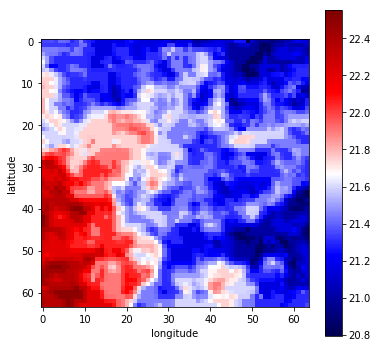

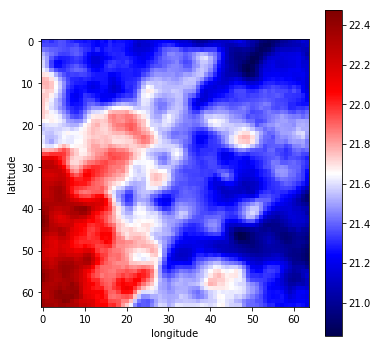

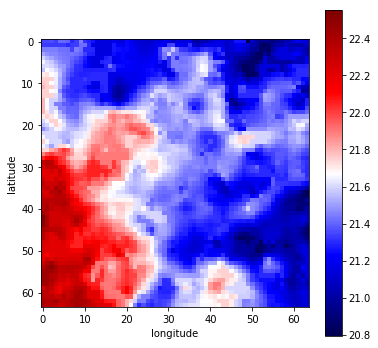

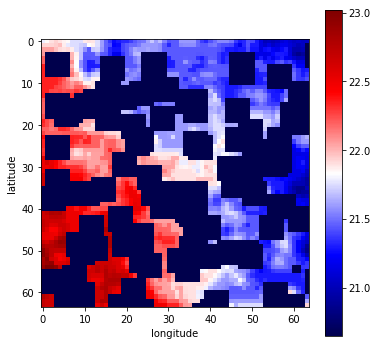

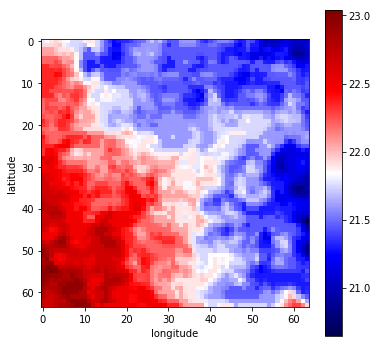

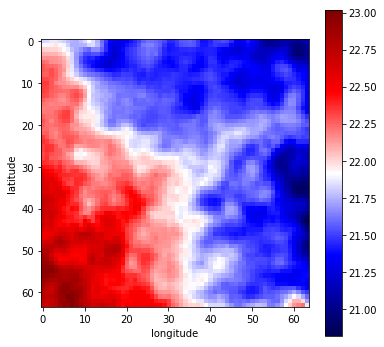

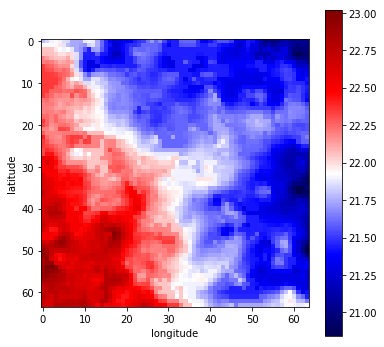

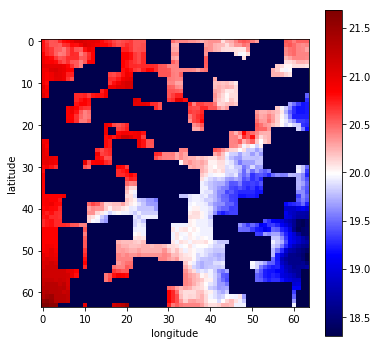

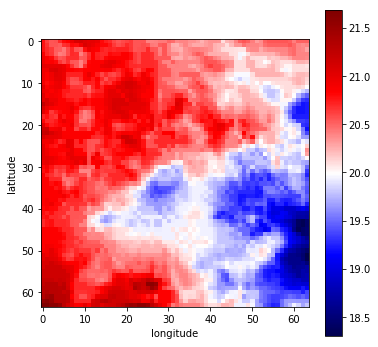

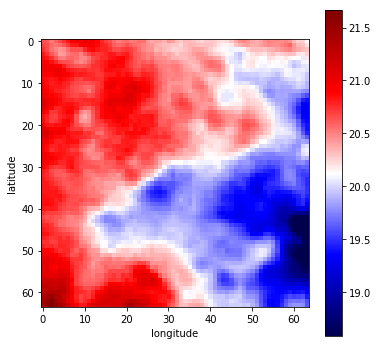

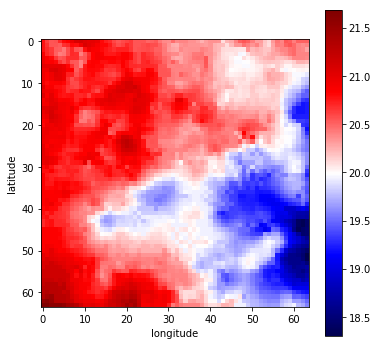

In [909]:
aauuxx3 = ts3.copy().reshape(ts3.shape[0],64,64)
for n in range(0,decoded_imgs6.shape[0]):
    for a in range(0,64):
        for b in range(0,64):
            if aauuxx3[n][a,b]==0:
                aauuxx3[n][a,b]=decoded_imgs6[n][a,b]
                
aauuxx3_orig = np.ones(aauuxx3.shape)
for index in range(0,aauuxx3.shape[0]):
    aauuxx3_orig[index] = (aauuxx3[index]-3)*test3[index][np.nonzero(test3[index])].std()+ \
                                    test3[index][np.nonzero(test3[index])].mean()
###############################
plt.figure(figsize=(6,6))
plt.imshow(xreal3[im_ind],vmin=ytest_o[im_ind].min(),cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(ytest_o[im_ind],vmin=21,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs_orig6[im_ind],vmin=21,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(aauuxx3_orig[im_ind],vmin=21,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
###############################
plt.figure(figsize=(6,6))
plt.imshow(xreal3[im_ind+11],vmin=ytest_o[im_ind+11].min(),cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(ytest_o[im_ind+11],vmin=21,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs_orig6[im_ind+11],vmin=21,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(aauuxx3_orig[im_ind+11],vmin=21,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
###############################
plt.figure(figsize=(6,6))
plt.imshow(xreal3[im_ind+6],vmin=ytest_o[im_ind+6].min(),cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(ytest_o[im_ind+6],vmin=21,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs_orig6[im_ind+6],vmin=21,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(aauuxx3_orig[im_ind+6],vmin=21,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

In [966]:
# rmse in zone without holes
rmse5_without = []
for index in range(0,test3.shape[0]):
    rmse_indiv = math.sqrt(np.sum((decoded_imgs_orig5[index][np.nonzero(test3[index])] - \
                     xtest_o[index][np.nonzero(test3[index])])**2)/(np.asarray(np.nonzero(test3[index])).shape[0]*np.asarray(np.nonzero(test3[index])).shape[1]))
    rmse5_without.append(rmse_indiv)
rmse5_without = np.asarray(rmse5_without)
rmse5_without.mean()

0.03763713921357683

In [965]:
# rmse in zone with holes
rmse5_with = []
for index in range(0,test3.shape[0]):
    rmse_indiv = math.sqrt(np.sum((decoded_imgs_orig5[index][np.where(test3[index]==0)] - \
                     xtest_o[index][np.where(test3[index]==0)])**2)/(np.asarray(np.where(test3[index]==0)).shape[0]*np.asarray(np.where(test3[index]==0)).shape[1]))
    rmse5_with.append(rmse_indiv)
rmse5_with = np.asarray(rmse5_with)
rmse5_with.mean()

0.037628310132790756

In [969]:
# rmse of the total image
rmse5_with = []
for index in range(0,test3.shape[0]):
    rmse_indiv = math.sqrt(np.sum((decoded_imgs_orig5[index] - \
                     xtest_o[index])**2)/(64*64))
    rmse5_with.append(rmse_indiv)
rmse5_with = np.asarray(rmse5_with)
rmse5_with.mean()

0.05338446451495701

In [961]:
# rmse in zone without holes
rmse6_without = []
for index in range(0,test3.shape[0]):
    rmse_indiv = math.sqrt(np.sum((decoded_imgs_orig6[index][np.nonzero(test3[index])] - \
                     xtest_o[index][np.nonzero(test3[index])])**2)/(np.asarray(np.nonzero(test3[index])).shape[0]*np.asarray(np.nonzero(test3[index])).shape[1]))
    rmse6_without.append(rmse_indiv)
rmse6_without = np.asarray(rmse6_without)
rmse6_without.mean()

0.08484338566958194

In [957]:
# rmse in zones with holes
rmse6_with = []
for index in range(0,test3.shape[0]):
    rmse_indiv = math.sqrt(np.sum((decoded_imgs_orig6[index][np.where(test3[index]==0)] - \
                     xtest_o[index][np.where(test3[index]==0)])**2)/(np.asarray(np.where(test3[index]==0)).shape[0]*np.asarray(np.where(test3[index]==0)).shape[1]))
    rmse6_with.append(rmse_indiv)
rmse6_with = np.asarray(rmse6_with)
rmse6_with.mean()

0.08761287630975373

In [960]:
# rmse of the total image
rmse6_tot = []
for index in range(0,test3.shape[0]):
    rmse_indiv = math.sqrt(np.sum((decoded_imgs_orig6[index] - \
                     xtest_o[index])**2)/(64*64))
    rmse6_tot.append(rmse_indiv)
rmse6_tot = np.asarray(rmse6_tot)
rmse6_tot.mean()

0.12235115594467194

In [949]:
pd.DataFrame(rmse6_with)

,0
0,3.956565
1,8.483156
2,5.418002
3,5.634625
4,7.871692
5,9.884855
6,4.355626
7,3.989848
8,4.874175
9,6.178003


In [548]:
import math
# denormalization of predicted outputs \ rmse of pred vs real output
# autoencoder to determine one hole
decoded_imgs_orig = np.ones(decoded_imgs.shape)
rmse = []
for index in range(0,decoded_imgs.shape[0]):
    decoded_imgs_orig[index] = decoded_imgs[index]*xtest_o[index].std()+xtest_o[index].mean()
    rmse.append(math.sqrt(np.sum((decoded_imgs_orig[index].reshape(-1,1)- \
                                  xtest_o[index].reshape(-1,1))**2)))
# autoencoder to determine mult holes
decoded_imgs_orig3 = np.ones(decoded_imgs3.shape)
rmse3 = []
for index in range(0,decoded_imgs3.shape[0]):
    decoded_imgs_orig3[index] = decoded_imgs3[index]*xtest_o[index].std()+xtest_o[index].mean()
    rmse3.append(math.sqrt(np.sum((decoded_imgs_orig3[index].reshape(-1,1)- \
                                   xtest_o[index].reshape(-1,1))**2)))
# gan to determine one hole
decoded_imgs_orig5 = np.ones(decoded_imgs5.shape)
rmse5 = []
for index in range(0,decoded_imgs5.shape[0]):
    decoded_imgs_orig5[index] = (decoded_imgs5[index]-3)*xtest_o[index].std()+xtest_o[index].mean()
    rmse5.append(math.sqrt(np.sum((decoded_imgs_orig5[index].reshape(-1,1)- \
                                   xtest_o[index].reshape(-1,1))**2)))
# gan to determine mult holes
decoded_imgs_orig6 = np.ones(decoded_imgs6.shape)
rmse6 = []
for index in range(0,decoded_imgs6.shape[0]):
    decoded_imgs_orig6[index] = (decoded_imgs6[index]-3)*xtest_o[index].std()+xtest_o[index].mean()
    rmse6.append(math.sqrt(np.sum((decoded_imgs_orig6[index].reshape(-1,1)- \
                                   xtest_o[index].reshape(-1,1))**2)))

In [880]:
aauuxx2_orig = np.ones(aauuxx2.shape)
rmse_aauuxx2 = []
for index in range(0,aauuxx2.shape[0]):
    aauuxx2_orig[index] = (aauuxx2[index]-3)*xtest_o[index].std()+xtest_o[index].mean()
    rmse_aauuxx2.append(math.sqrt(np.sum((aauuxx2_orig[index].reshape(-1,1)- \
                                   xtest_o[index].reshape(-1,1))**2)))

aauuxx3_orig = np.ones(aauuxx3.shape)
rmse_aauuxx3 = []
for index in range(0,aauuxx3.shape[0]):
    aauuxx3_orig[index] = (aauuxx3[index]-3)*xtest_o[index].std()+xtest_o[index].mean()
    rmse_aauuxx3.append(math.sqrt(np.sum((aauuxx3_orig[index].reshape(-1,1)- \
                                   xtest_o[index].reshape(-1,1))**2)))

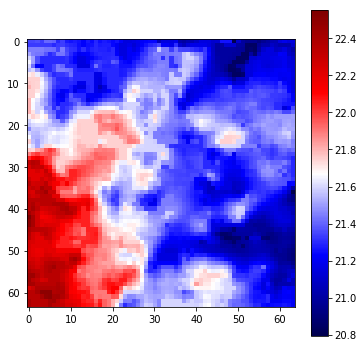

In [572]:
plt.figure(figsize=(6,6))
plt.imshow(aauuxx3_orig[im_ind],cmap='seismic')
plt.colorbar()

In [231]:
yreal2.shape,yreal3.shape

((207, 64, 64), (207, 64, 64))

In [550]:
# rmse values 
rmse = np.asarray(rmse) # autoenocoder's pred with 1 hole
rmse3 = np.asarray(rmse3) # autoencoder's pred with n holes
rmse5 = np.asarray(rmse5) # gan's pred with 1 hole
rmse6 = np.asarray(rmse6) # gan's pred with n holes
rmse_aauuxx2 = np.asarray(rmse_aauuxx2)
rmse_aauuxx3 = np.asarray(rmse_aauuxx3)

In [516]:
rmse_aauuxx2[im_ind],[im_ind]

(1.2545733313455254, 5.208755337213581)

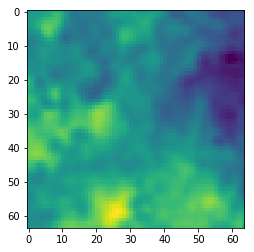

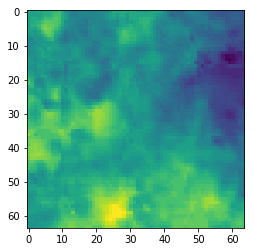

In [551]:
# image diff between y_pred and y_real for each of the aforementioned cases
imdiff_1hole1 = decoded_imgs_orig - ytest_o
imdiff_nhole1 = decoded_imgs_orig3 - ytest_o
imdiff_1hole2 = aauuxx2_orig - ytest_o#decoded_imgs_orig5 - xtest_o
imdiff_nhole2 = aauuxx3_orig - ytest_o#decoded_imgs_orig6 - xtest_o

imdiff_1hole22 = decoded_imgs_orig5 - ytest_o
imdiff_nhole22 = decoded_imgs_orig6 - ytest_o

plt.figure()
plt.imshow(decoded_imgs_orig5[im_ind+23])
plt.figure()
plt.imshow(aauuxx2_orig[im_ind+23])


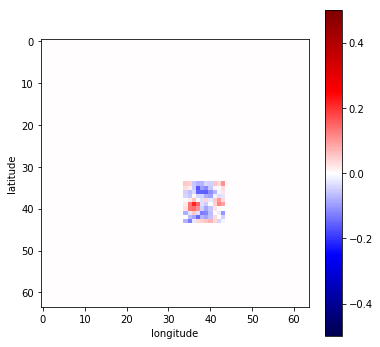

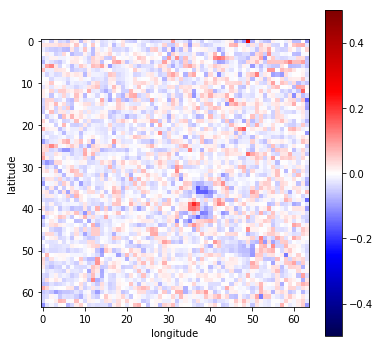

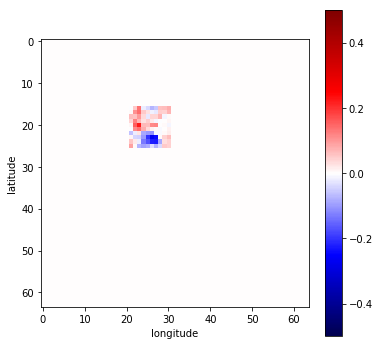

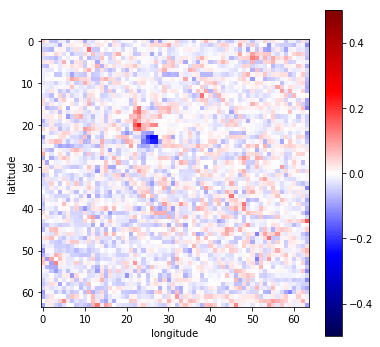

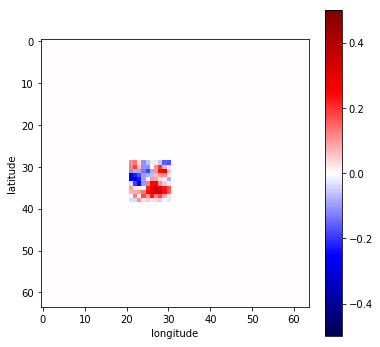

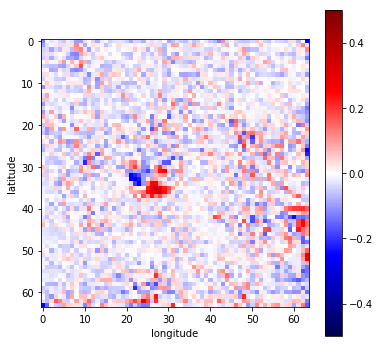

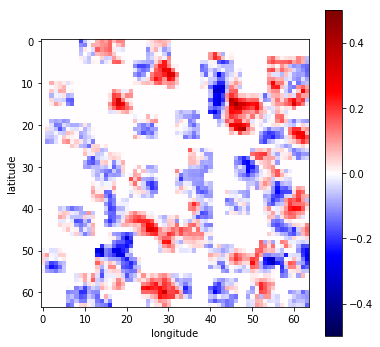

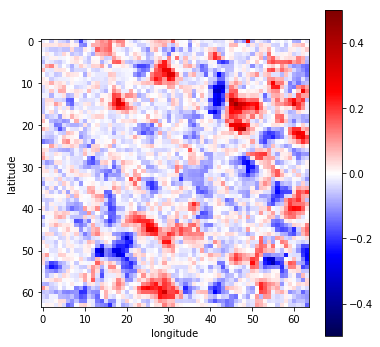

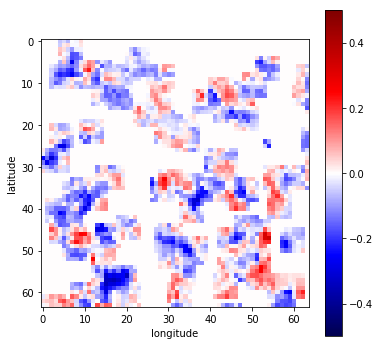

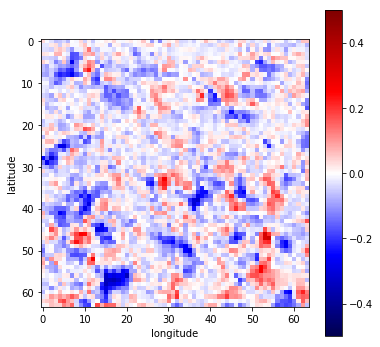

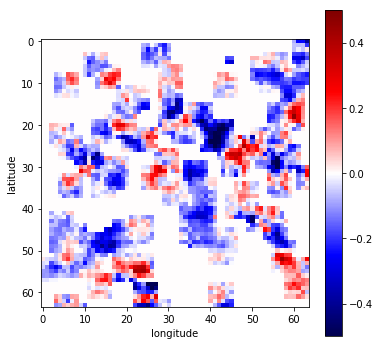

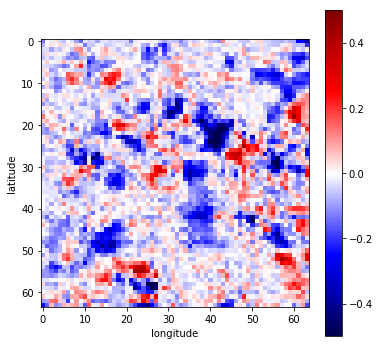

In [921]:
plt.figure(figsize=(6,6))
plt.imshow(imdiff_1hole2[im_ind],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
plt.figure(figsize=(6,6))
plt.imshow(imdiff_1hole22[im_ind],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(imdiff_1hole2[im_ind+11],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
plt.figure(figsize=(6,6))
plt.imshow(imdiff_1hole22[im_ind+11],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(imdiff_1hole2[im_ind+6],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
plt.figure(figsize=(6,6))
plt.imshow(imdiff_1hole22[im_ind+6],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(imdiff_nhole2[im_ind],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
plt.figure(figsize=(6,6))
plt.imshow(imdiff_nhole22[im_ind],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(imdiff_nhole2[im_ind+11],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
plt.figure(figsize=(6,6))
plt.imshow(imdiff_nhole22[im_ind+11],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(imdiff_nhole2[im_ind+6],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
plt.figure(figsize=(6,6))
plt.imshow(imdiff_nhole22[im_ind+6],vmin=-0.5,vmax=0.5,cmap='seismic')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

In [919]:
rmse5_without = []
rmse5_with = []
for index in range(0,imdiff_1hole22.shape[0]):
    rmse5_without.append(math.sqrt(np.sum(imdiff_1hole22[index][np.nonzero(test3[index])]**2)))

for index in range(0,imdiff_1hole22.shape[0]):
    rmse5_with.append(math.sqrt(np.sum(imdiff_1hole22[index][np.where(test3[index]==0)]**2)))

rmse5_with = np.asarray(rmse5_with)
rmse5_without = np.asarray(rmse5_without)
rmse5_with.mean(),rmse5_without.mean()

(2.5197513985019833, 2.2908022969506554)

In [920]:
rmse6_without = []
rmse6_with = []
for index in range(0,imdiff_nhole22.shape[0]):
    rmse6_without.append(math.sqrt(np.sum(imdiff_nhole22[index][np.nonzero(test3[index])]**2)))

for index in range(0,imdiff_nhole22.shape[0]):
    rmse6_with.append(math.sqrt(np.sum(imdiff_nhole22[index][np.where(test3[index]==0)]**2)))

rmse6_with = np.asarray(rmse6_with)
rmse6_without = np.asarray(rmse6_without)
rmse6_with.mean(),rmse6_without.mean()

(5.865935856945567, 5.164284874628869)

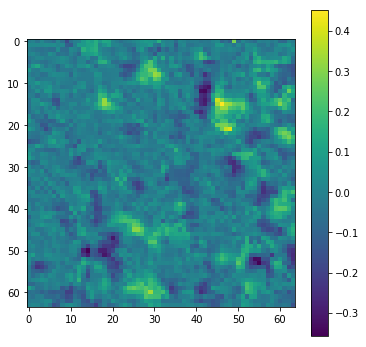

In [526]:
t = decoded_imgs_orig6[im_ind] - xtest_o[im_ind]

plt.figure(figsize=(6,6))
plt.imshow(t)
plt.colorbar()

Text(0,0.5,'real values')

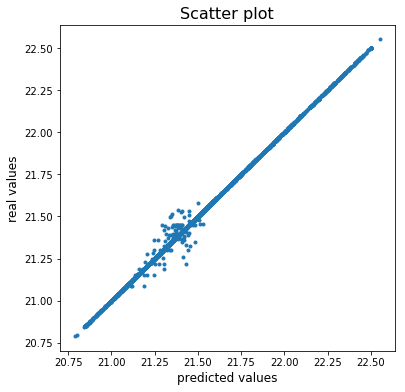

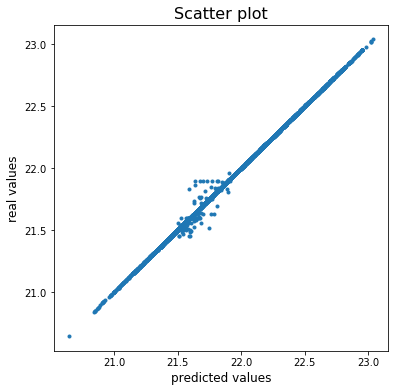

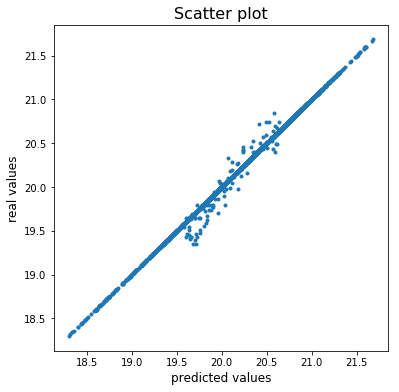

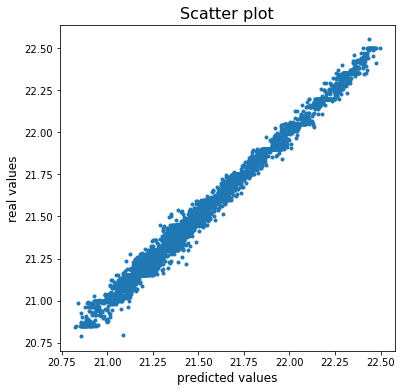

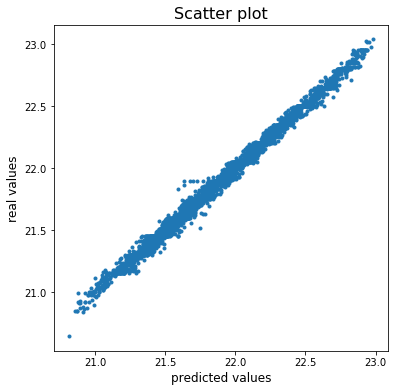

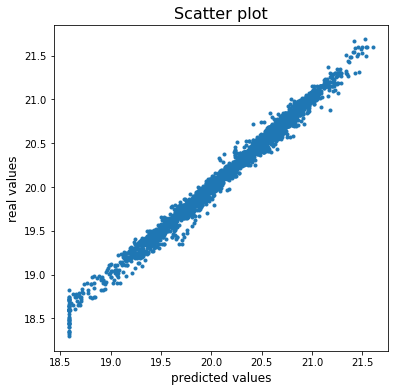

In [556]:
plt.figure(figsize=(6,6))
plt.plot(aauuxx2_orig[im_ind].reshape(-1,1),xtest_o[im_ind].reshape(-1,1),'.')
plt.title('Scatter plot',fontsize=16)
plt.xlabel('predicted values',fontsize=12)
plt.ylabel('real values',fontsize=12)

plt.figure(figsize=(6,6))
plt.plot(aauuxx2_orig[im_ind+11].reshape(-1,1),xtest_o[im_ind+11].reshape(-1,1),'.')
plt.title('Scatter plot',fontsize=16)
plt.xlabel('predicted values',fontsize=12)
plt.ylabel('real values',fontsize=12)

plt.figure(figsize=(6,6))
plt.plot(aauuxx2_orig[im_ind+6].reshape(-1,1),xtest_o[im_ind+6].reshape(-1,1),'.')
plt.title('Scatter plot',fontsize=16)
plt.xlabel('predicted values',fontsize=12)
plt.ylabel('real values',fontsize=12)

plt.figure(figsize=(6,6))
plt.plot(decoded_imgs_orig5[im_ind].reshape(-1,1),xtest_o[im_ind].reshape(-1,1),'.')
plt.title('Scatter plot',fontsize=16)
plt.xlabel('predicted values',fontsize=12)
plt.ylabel('real values',fontsize=12)

plt.figure(figsize=(6,6))
plt.plot(decoded_imgs_orig5[im_ind+11].reshape(-1,1),xtest_o[im_ind+11].reshape(-1,1),'.')
plt.title('Scatter plot',fontsize=16)
plt.xlabel('predicted values',fontsize=12)
plt.ylabel('real values',fontsize=12)

plt.figure(figsize=(6,6))
plt.plot(decoded_imgs_orig5[im_ind+6].reshape(-1,1),xtest_o[im_ind+6].reshape(-1,1),'.')
plt.title('Scatter plot',fontsize=16)
plt.xlabel('predicted values',fontsize=12)
plt.ylabel('real values',fontsize=12)

Text(0,0.5,'real values')

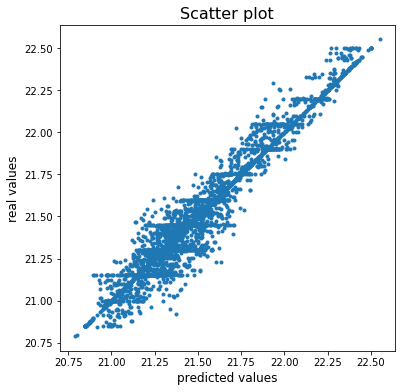

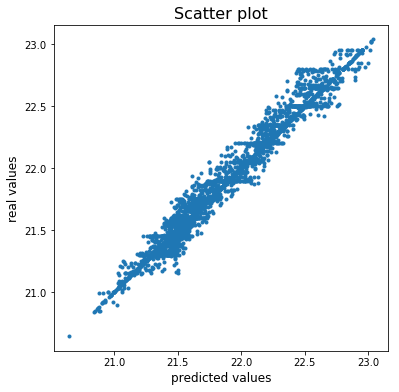

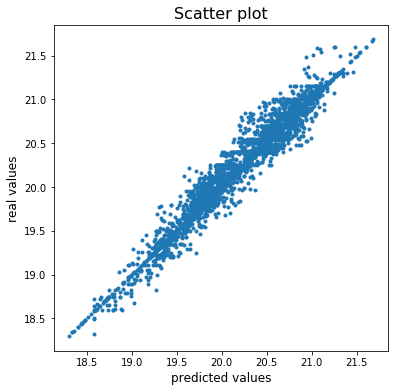

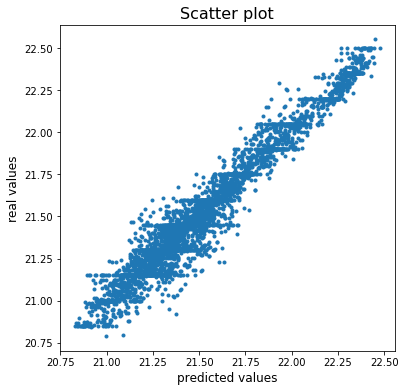

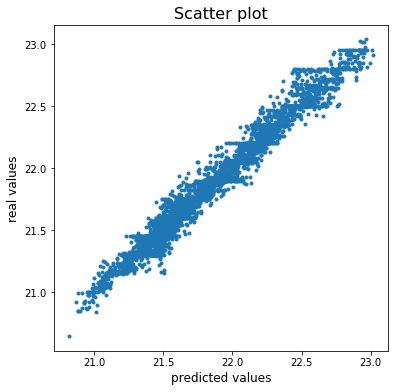

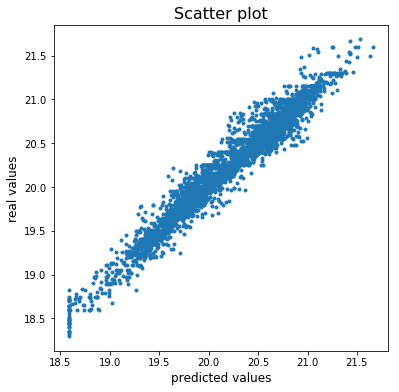

In [561]:
plt.figure(figsize=(6,6))
plt.plot(aauuxx3_orig[im_ind].reshape(-1,1),xtest_o[im_ind].reshape(-1,1),'.')
plt.title('Scatter plot',fontsize=16)
plt.xlabel('predicted values',fontsize=12)
plt.ylabel('real values',fontsize=12)

plt.figure(figsize=(6,6))
plt.plot(aauuxx3_orig[im_ind+11].reshape(-1,1),xtest_o[im_ind+11].reshape(-1,1),'.')
plt.title('Scatter plot',fontsize=16)
plt.xlabel('predicted values',fontsize=12)
plt.ylabel('real values',fontsize=12)

plt.figure(figsize=(6,6))
plt.plot(aauuxx3_orig[im_ind+6].reshape(-1,1),xtest_o[im_ind+6].reshape(-1,1),'.')
plt.title('Scatter plot',fontsize=16)
plt.xlabel('predicted values',fontsize=12)
plt.ylabel('real values',fontsize=12)

plt.figure(figsize=(6,6))
plt.plot(decoded_imgs_orig6[im_ind].reshape(-1,1),xtest_o[im_ind].reshape(-1,1),'.')
plt.title('Scatter plot',fontsize=16)
plt.xlabel('predicted values',fontsize=12)
plt.ylabel('real values',fontsize=12)

plt.figure(figsize=(6,6))
plt.plot(decoded_imgs_orig6[im_ind+11].reshape(-1,1),xtest_o[im_ind+11].reshape(-1,1),'.')
plt.title('Scatter plot',fontsize=16)
plt.xlabel('predicted values',fontsize=12)
plt.ylabel('real values',fontsize=12)

plt.figure(figsize=(6,6))
plt.plot(decoded_imgs_orig6[im_ind+6].reshape(-1,1),xtest_o[im_ind+6].reshape(-1,1),'.')
plt.title('Scatter plot',fontsize=16)
plt.xlabel('predicted values',fontsize=12)
plt.ylabel('real values',fontsize=12)